In [1]:
import os
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, f1_score, matthews_corrcoef
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.utils import to_categorical

import re
import keras
import pandas as pd
from glob import glob
import tensorflow as tf
import tensorflow.image as tfi

# Data
from tensorflow.keras.utils import to_categorical


# Model
from keras.models import Model
from keras.layers import Layer
from keras.layers import Conv2D
from keras.layers import Dropout
from keras.layers import UpSampling2D
from keras.layers import concatenate
from keras.layers import Add
from keras.layers import Multiply
from keras.layers import Input
from keras.layers import MaxPool2D
from keras.layers import BatchNormalization

# Callbacks
from keras.callbacks import Callback
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

# Metrics
from keras.metrics import MeanIoU

In [2]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import to_categorical

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import UpSampling2D, Conv2D, BatchNormalization, Activation, Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, Activation, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as K
from tensorflow.keras.metrics import AUC
from sklearn.metrics import roc_curve, auc

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Sep  1 02:18:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA L4                      Off | 00000000:00:03.0 Off |                    0 |
| N/A   38C    P0              16W /  72W |    191MiB / 23034MiB |      2%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [7]:
def load_image(image, SIZE):
    return np.round(tfi.resize(img_to_array(load_img(image))/255.,(SIZE, SIZE)),4)

def load_images(image_paths, SIZE, mask=False, trim=None):
    if trim is not None:
        image_paths = image_paths[:trim]

    if mask:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 1))
    else:
        images = np.zeros(shape=(len(image_paths), SIZE, SIZE, 3))

    for i,image in enumerate(image_paths):
        img = load_image(image,SIZE)
        if mask:
            images[i] = img[:,:,:1]
        else:
            images[i] = img

    return images

In [8]:
# Defining directories

root_path_BM = r'/content/drive/MyDrive/Dissertation/Dataset/Full Data/BM'
root_path_FM = r'/content/drive/MyDrive/Dissertation/Dataset/Full Data/FM'
augmented_path_BM = r'/content/drive/MyDrive/Dissertation/Dataset/augmented data/BM'
augmented_path_FM = r'/content/drive/MyDrive/Dissertation/Dataset/augmented data/FM'

# Creating directories for augmented data if they don't exist
os.makedirs(augmented_path_BM, exist_ok=True)
os.makedirs(augmented_path_FM, exist_ok=True)

print(f"BM Path: {root_path_BM}")
print(f"FM Path: {root_path_FM}")

BM Path: /content/drive/MyDrive/Dissertation/Dataset/Full Data/BM
FM Path: /content/drive/MyDrive/Dissertation/Dataset/Full Data/FM


In [9]:
import glob
# Function to get sorted file paths
def get_paths(root_path, image_exts):
    image_paths = []
    for ext in image_exts:
        image_paths.extend(glob.glob(os.path.join(root_path, f'*{ext}')))
    return image_paths

# Get sorted paths for BM and FM datasets
images_BM = get_paths(root_path_BM, ['.jpg', '.jpeg'])
images_FM = get_paths(root_path_FM, ['.jpg', '.jpeg'])

# Define labels for each category
labels_BM = [0] * len(images_BM)  # Label 0 for BM
labels_FM = [1] * len(images_FM)  # Label 1 for FM

# Combining images and labels
all_images = images_BM + images_FM
all_labels = labels_BM + labels_FM

# Converting labels to categorical
labels = to_categorical(all_labels, num_classes=2)

In [10]:
# Data augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [59]:
# Function to load and preprocess images
def load_and_preprocess_image(image_path):
    img = load_img(image_path, target_size=(256, 256))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Function to augment and save images
def augment_and_save_images(image_paths, datagen, save_dir, num_augmented=3):
    for img_path in image_paths:
        img = load_and_preprocess_image(img_path)
        img_gen = datagen.flow(img, batch_size=1)

        for i in range(num_augmented):
            augmented_img = next(img_gen)[0]
            augmented_img = array_to_img(augmented_img)
            base_name = os.path.basename(img_path)
            name, ext = os.path.splitext(base_name)
            augmented_img.save(os.path.join(save_dir, f'{name}_aug_{i}{ext}'))

In [60]:
# Augment and save images for both BM and FM datasets
augment_and_save_images(images_BM, datagen, augmented_path_BM)
augment_and_save_images(images_FM, datagen, augmented_path_FM)

In [61]:
# Function to get both original and augmented image paths
def get_all_image_paths(original_dirs, augmented_dirs, image_exts):
    all_paths = []
    for directory in original_dirs + augmented_dirs:
    #for directory in original_dirs:
        all_paths.extend(get_paths(directory, image_exts))
    return all_paths

original_dirs_BM = [root_path_BM]
augmented_dirs_BM = [augmented_path_BM]
image_paths_BM = get_all_image_paths(original_dirs_BM, augmented_dirs_BM, ['.jpg', '.jpeg'])

original_dirs_FM = [root_path_FM]
augmented_dirs_FM = [augmented_path_FM]
image_paths_FM = get_all_image_paths(original_dirs_FM, augmented_dirs_FM, ['.jpg', '.jpeg'])



In [62]:
print(len(image_paths_BM))

1280


In [63]:
# Defining labels for each category
labels_BM = [0] * len(image_paths_BM)  # Label 0 for Actinomycetoma (BM)
labels_FM = [1] * len(image_paths_FM)  # Label 1 for Eumycetoma (FM)

# Combining images, masks, and labels
all_images_path = image_paths_BM + image_paths_FM
all_labels = labels_BM + labels_FM

# Converting labels to categorical
labels = to_categorical(all_labels, num_classes=2)

In [64]:
images = load_images(all_images_path, 256)

# **Evaluation Matrices: MCC, Precision, Recall,Specificity,F1 score, Confusion Matrix**

In [65]:
def mcc(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))

    numerator = (tp * tn) - (fp * fn)
    denominator = K.sqrt((tp + fp) * (tp + fn) * (tn + fp) * (tn + fn))

    return numerator / (denominator + K.epsilon())

def precision(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tp / (tp + fp + K.epsilon())

def recall(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')
    tp = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    fn = K.sum(K.round(K.clip(y_true * (1 - y_pred), 0, 1)))
    return tp / (tp + fn + K.epsilon())

def specificity(y_true, y_pred):
    y_true = K.cast(y_true, 'float32')
    y_pred = K.cast(K.round(y_pred), 'float32')
    tn = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    fp = K.sum(K.round(K.clip((1 - y_true) * y_pred, 0, 1)))
    return tn / (tn + fp + K.epsilon())

def f1_score(y_true, y_pred):
    prec = precision(y_true, y_pred)
    rec = recall(y_true, y_pred)
    return 2 * ((prec * rec) / (prec + rec + K.epsilon()))

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

def plot_confusion_matrix(y_true, y_pred, model_name="Model"):

    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()



In [66]:
def plot_roc_auc(model, X_val, y_val, model_name="Model"):

    # Predict probabilities for the positive class
    y_pred_prob = model.predict(X_val)

    # y_val is one-hot encoded, convert it to binary labels
    if y_val.ndim > 1 and y_val.shape[1] > 1:
        y_val = np.argmax(y_val, axis=1)

    if y_pred_prob.ndim > 1 and y_pred_prob.shape[1] > 1:
        y_pred_prob = y_pred_prob[:, 1]  # Select probabilities for class 1

    # Calculating the ROC curve
    fpr, tpr, thresholds = roc_curve(y_val, y_pred_prob)

    # Calculating the AUC
    roc_auc = auc(fpr, tpr)

    # Plotting the ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic - {model_name}')
    plt.legend(loc="lower right")
    plt.show()

In [67]:
# Splitting data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42)

In [68]:
SIZE = 256

In [69]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_val shape:", X_val.shape)
print("y_val shape:", y_val.shape)

X_train shape: (2188, 256, 256, 3)
y_train shape: (2188, 2)
X_val shape: (548, 256, 256, 3)
y_val shape: (548, 2)


In [70]:
def display_charts(h,var1, label1, h1, h2, h3):
    plt.figure(figsize=(12, 6))
    plt.plot(h.history[var1], label=label1)
    plt.title(h1)
    plt.xlabel(h2)
    plt.ylabel(h3)
    plt.legend()
    plt.show()

In [71]:
def display_charts_loss(h,var1, label1, var2, label2, h1, h2, h3):
    plt.figure(figsize=(12, 6))
    plt.plot(h.history[var1], label=label1)
    plt.plot(h.history[var2], label=label2)
    plt.title(h1)
    plt.xlabel(h2)
    plt.ylabel(h3)
    plt.legend()
    plt.show()

In [72]:
def display_result(h):
    hist = h
    display_charts_loss(hist,'loss','Training Loss', 'val_loss','Validation Loss','Training and Validation Loss', 'Epochs', 'Loss' )
    display_charts(hist, 'val_accuracy','Validation Accuracy','Accuracy', 'Epochs', 'Accuracy' )
    display_charts(hist, 'val_precision','Validation Precision','Precision', 'Epochs', 'precision' )
    display_charts(hist, 'val_recall','Validation recall','Recall', 'Epochs', 'recall' )
    display_charts(hist, 'val_specificity','Validation Specificity','Specificity', 'Epochs', 'specificity' )
    display_charts(hist, 'val_f1_score','Validation f1_score','f1_score', 'Epochs', 'f1_score' )
    display_charts(hist, 'val_mcc','Validation MCC','MCC', 'Epochs', 'MCC' )

In [73]:
def print_result():
    val_loss, val_accuracy, val_precision, val_recall, val_specificity,val_f1_score, val_auc, val_mcc  = model_base.evaluate(X_val, y_val)
    print(f"Validation Loss: {val_loss}")
    print(f"Validation Accuracy: {val_accuracy}")
    print(f"Validation precision: {val_precision}")
    print(f"Validation recall: {val_recall}")
    print(f"Validation specificity: {val_specificity}")
    print(f"Validation f1_score: {val_f1_score}")
    print(f"Validation AUC: {val_auc}")
    print(f"Validation MCC: {val_mcc}")

# **Building ResNet50 base model for binary classification**

In [74]:
def build_model(input_shape=(SIZE, SIZE, 3), num_classes=2):
    base_model = InceptionV3(include_top=False, weights='imagenet', input_shape=input_shape)

    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # Freeze the layers of base_model
    for layer in base_model.layers:
        layer.trainable = False

    return model

model_base = build_model()

# Compile the model
model_base.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy', precision,
        recall,
        specificity,
        f1_score,
        AUC(name='auc'), mcc])


In [75]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.keras', monitor='val_loss', mode='min', save_best_only=True)

#  Model Training
history_base = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=40,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/40
137/137 [==============================] - 16s 76ms/step - loss: 0.5309 - accuracy: 0.7514 - precision: 0.7514 - recall: 0.7514 - specificity: 0.7514 - f1_score: 0.7514 - auc: 0.8286 - mcc: 0.5027 - val_loss: 0.3724 - val_accuracy: 0.8558 - val_precision: 0.8589 - val_recall: 0.8589 - val_specificity: 0.8589 - val_f1_score: 0.8589 - val_auc: 0.9361 - val_mcc: 0.7179
Epoch 2/40
137/137 [==============================] - 4s 29ms/step - loss: 0.3760 - accuracy: 0.8410 - precision: 0.8409 - recall: 0.8409 - specificity: 0.8409 - f1_score: 0.8409 - auc: 0.9234 - mcc: 0.6819 - val_loss: 0.4077 - val_accuracy: 0.8084 - val_precision: 0.8071 - val_recall: 0.8071 - val_specificity: 0.8071 - val_f1_score: 0.8071 - val_auc: 0.8974 - val_mcc: 0.6143
Epoch 3/40
137/137 [==============================] - 5s 38ms/step - loss: 0.3129 - accuracy: 0.8803 - precision: 0.8805 - recall: 0.8805 - specificity: 0.8805 - f1_score: 0.8805 - auc: 0.9472 - mcc: 0.7609 - val_loss: 0.2819 - val_accuracy:

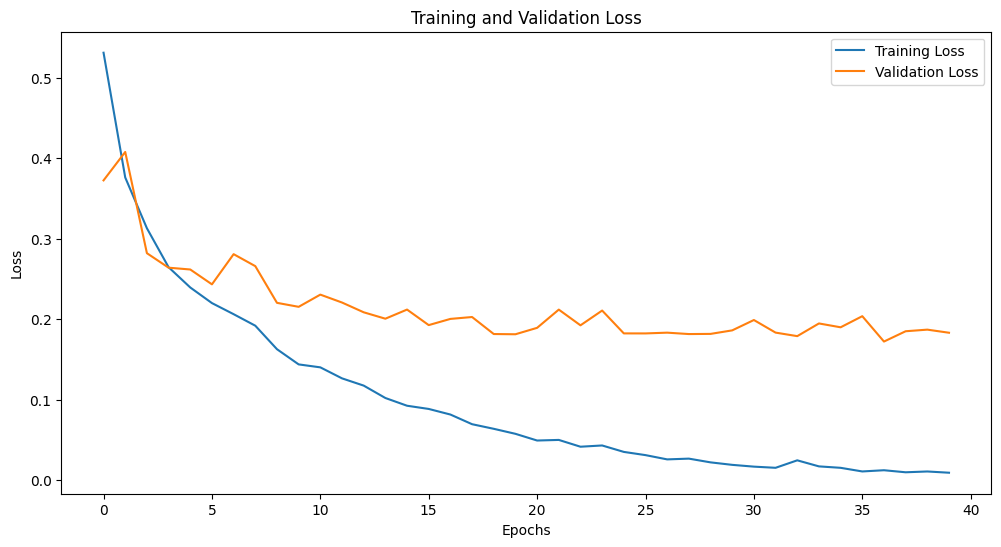

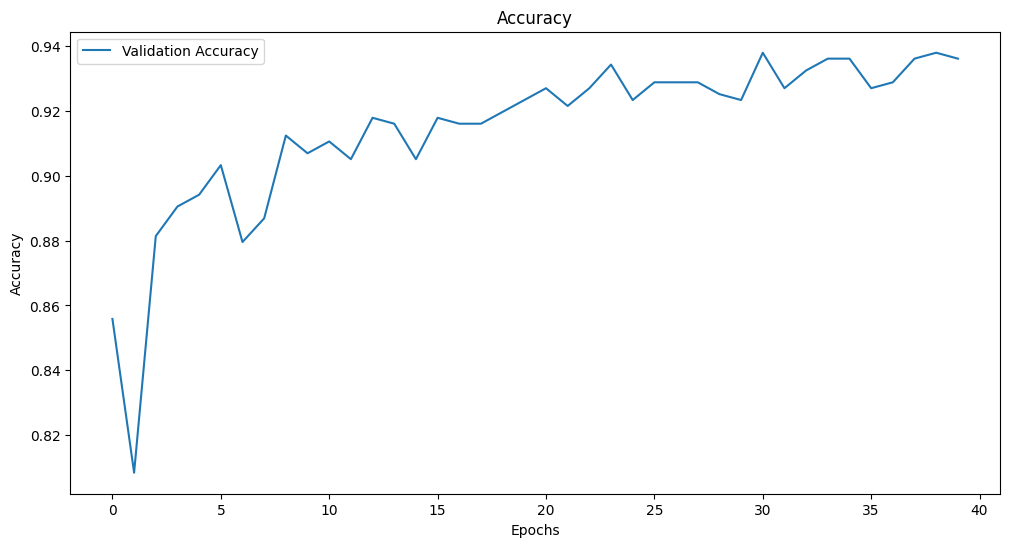

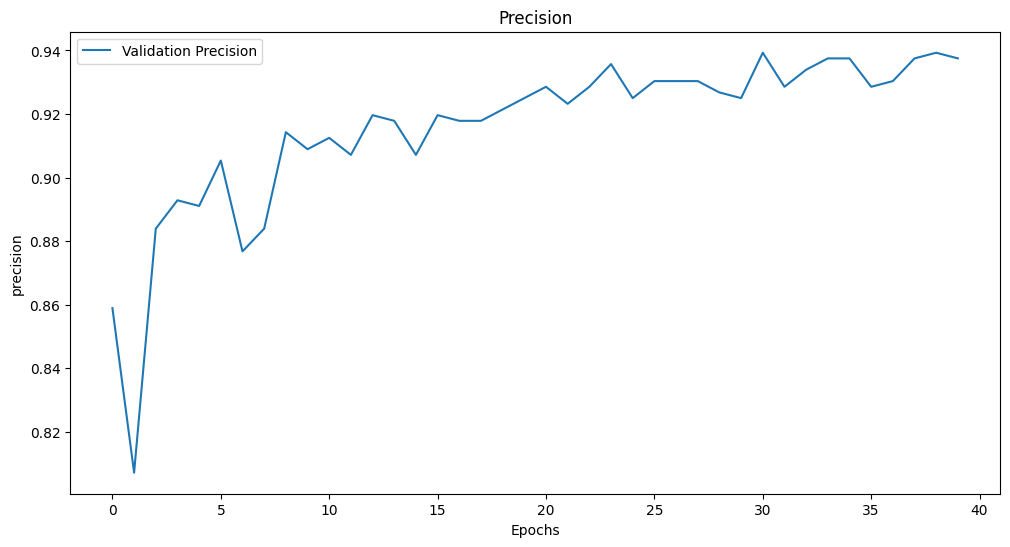

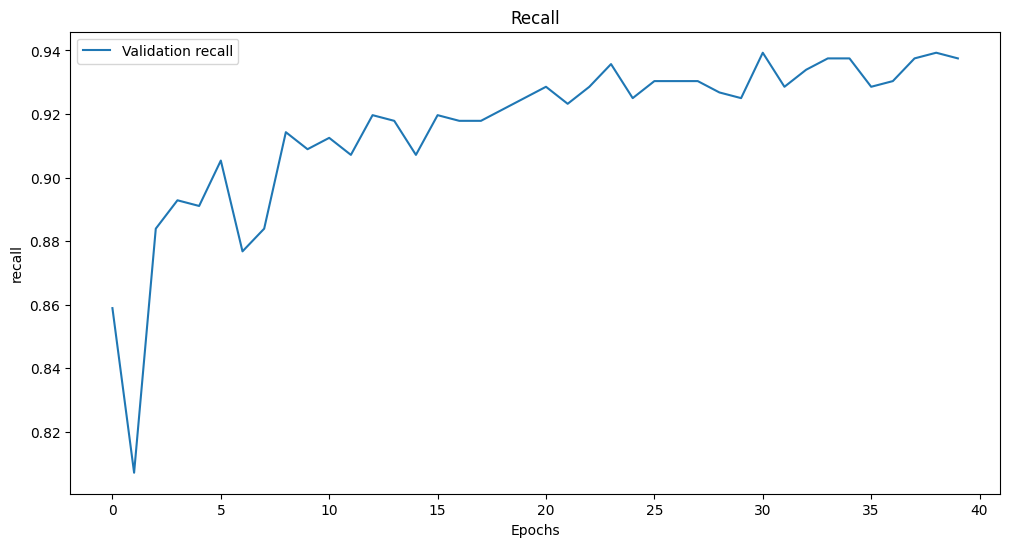

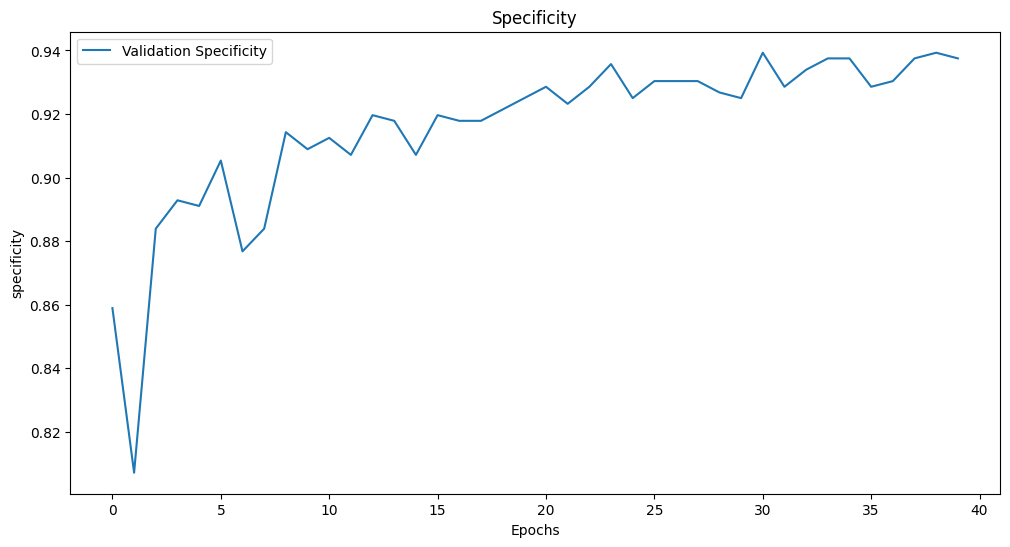

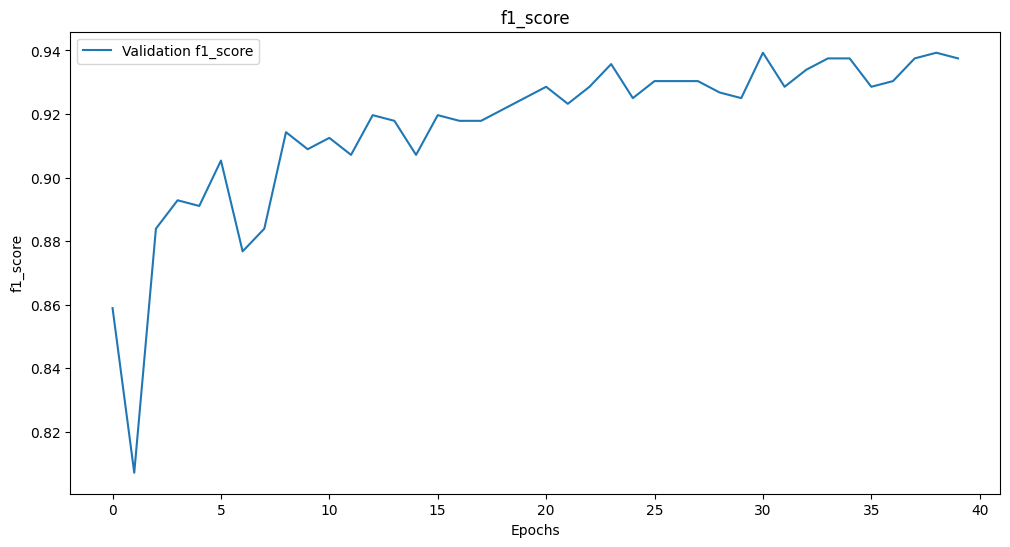

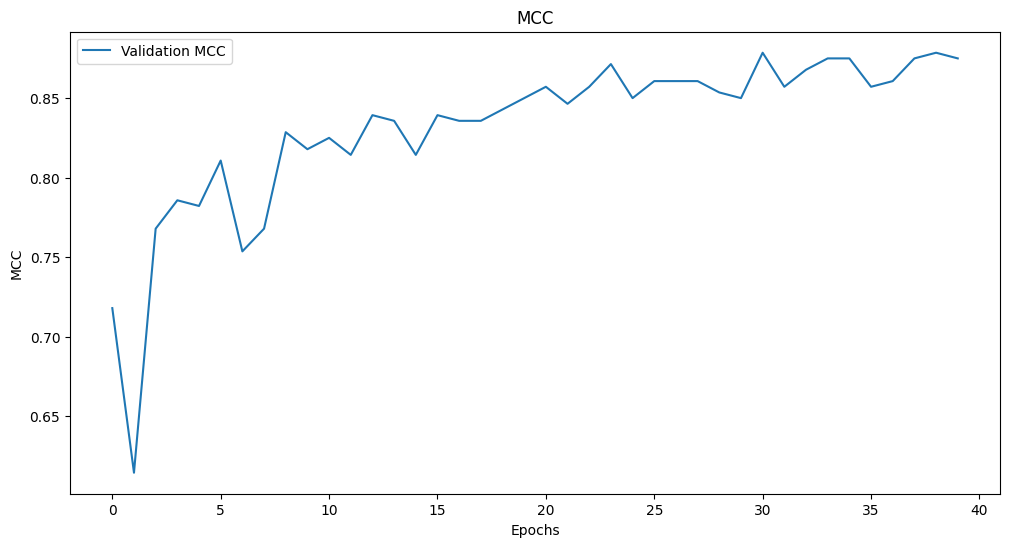

In [76]:
display_result(history_base)

In [77]:
print_result()

18/18 [==============================] - 1s 39ms/step - loss: 0.1831 - accuracy: 0.9361 - precision: 0.9392 - recall: 0.9392 - specificity: 0.9392 - f1_score: 0.9392 - auc: 0.9731 - mcc: 0.8785
Validation Loss: 0.18311986327171326
Validation Accuracy: 0.9361313581466675
Validation precision: 0.9392361044883728
Validation recall: 0.9392361044883728
Validation specificity: 0.9392361044883728
Validation f1_score: 0.9392361044883728
Validation AUC: 0.9730640053749084
Validation MCC: 0.8784722089767456


18/18 [==============================] - 2s 36ms/step


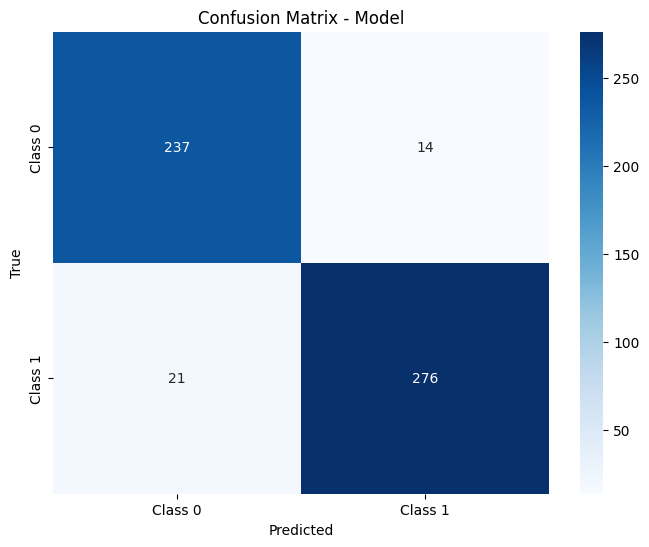

18/18 [==============================] - 1s 36ms/step


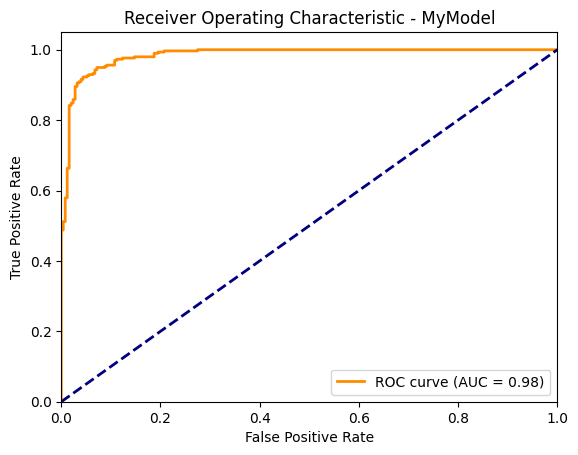

F1 Score: 0.9403747320175171


In [78]:
# Making predictions on the validation set
y_pred_probabilities = model_base.predict(X_val)

# Converting predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Converting true labels to class labels to one-hot encoded
y_true_classes = np.argmax(y_val, axis=1)

# Ploting the confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes)

plot_roc_auc(model_base, X_val, y_val, model_name="MyModel")

f1 = f1_score(y_true_classes, y_pred_classes)
print(f'F1 Score: {f1}')

# **Fine-tuning ResNet50: Unfreezing the last 2 layers**

In [79]:
# Unfreeze top 2 layers
for layer in model_base.layers[-2:]:
    layer.trainable = True

# Compile the model
model_base.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', mcc, precision,
        recall,
        specificity,
        f1_score,
        AUC(name='auc')])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_IL2.keras', monitor='val_loss', mode='min', save_best_only=True)

#  Model Training
history_fine_tune_L2 = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=50,
    batch_size=16,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/50
137/137 [==============================] - 13s 59ms/step - loss: 0.0060 - accuracy: 1.0000 - mcc: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity: 1.0000 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.1817 - val_accuracy: 0.9325 - val_mcc: 0.8679 - val_precision: 0.9339 - val_recall: 0.9339 - val_specificity: 0.9339 - val_f1_score: 0.9339 - val_auc: 0.9735
Epoch 2/50
137/137 [==============================] - 4s 29ms/step - loss: 0.0057 - accuracy: 1.0000 - mcc: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity: 1.0000 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.1818 - val_accuracy: 0.9343 - val_mcc: 0.8714 - val_precision: 0.9357 - val_recall: 0.9357 - val_specificity: 0.9357 - val_f1_score: 0.9357 - val_auc: 0.9734
Epoch 3/50
137/137 [==============================] - 4s 29ms/step - loss: 0.0056 - accuracy: 1.0000 - mcc: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity: 1.0000 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.1843 - val_accuracy:

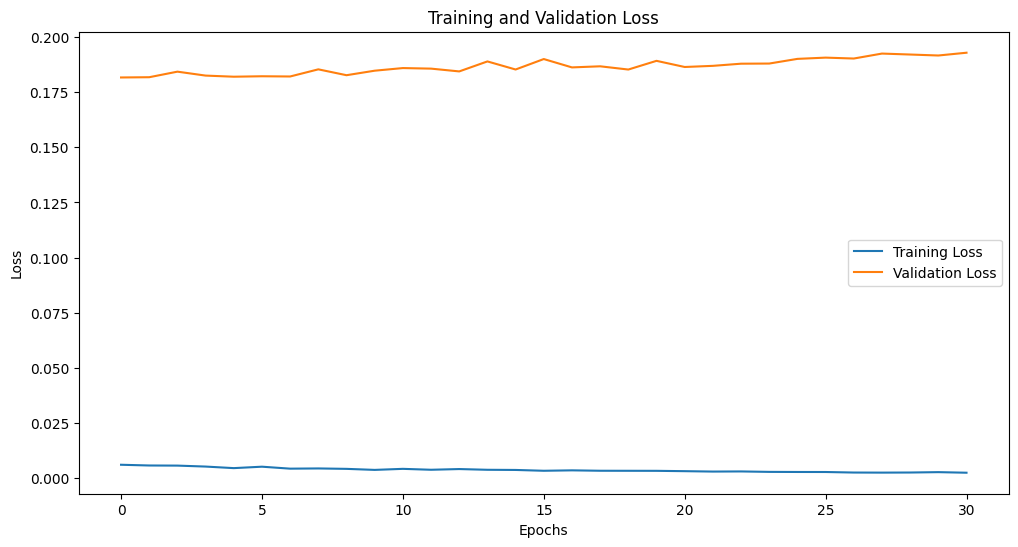

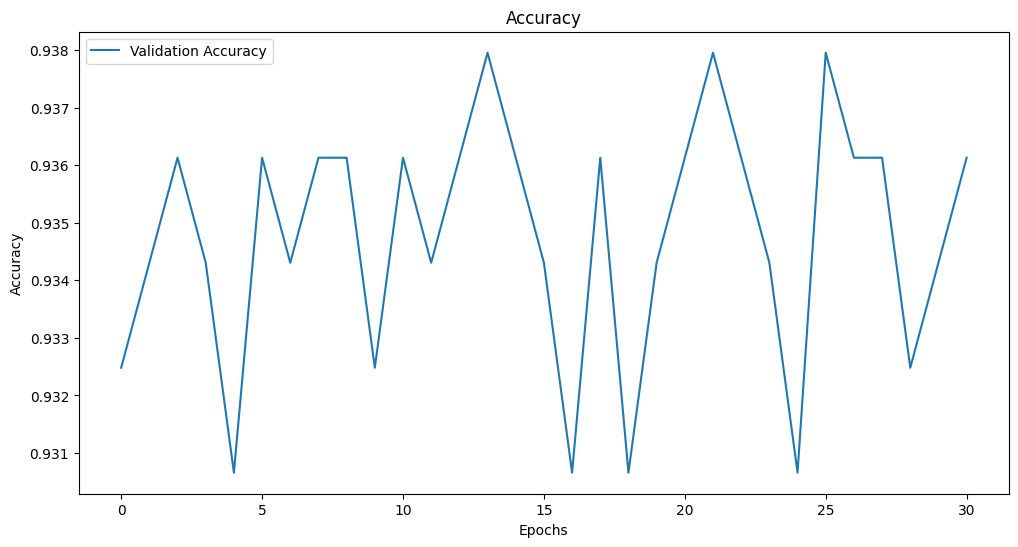

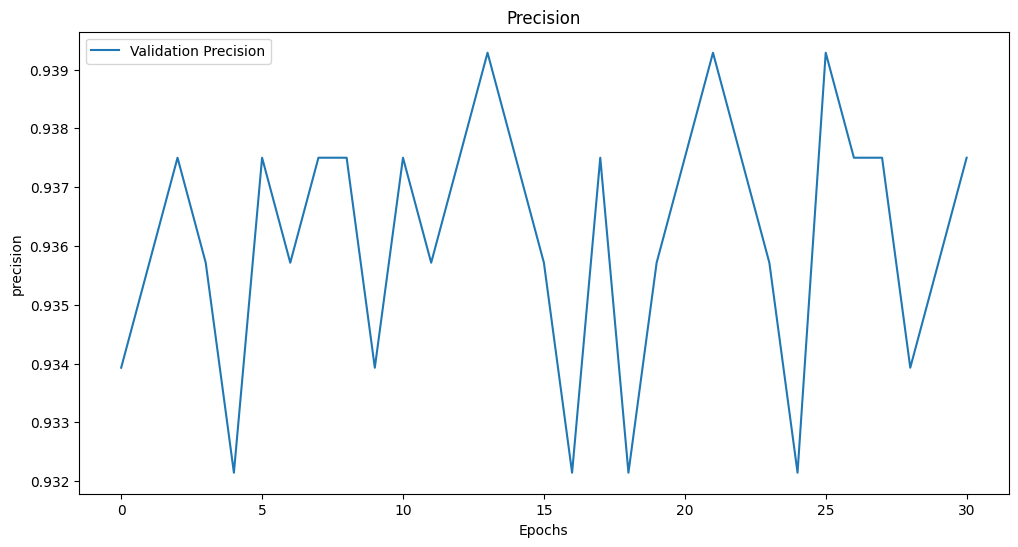

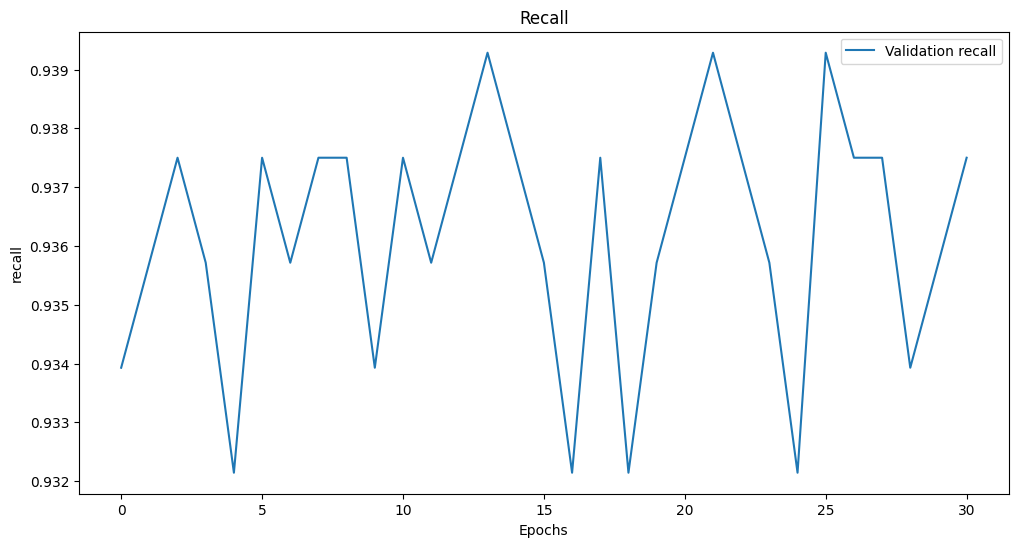

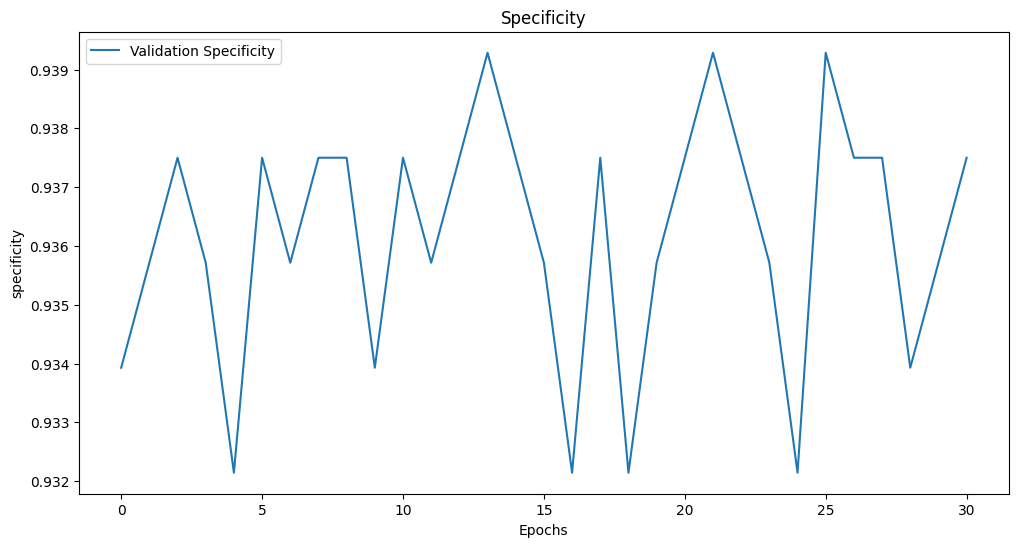

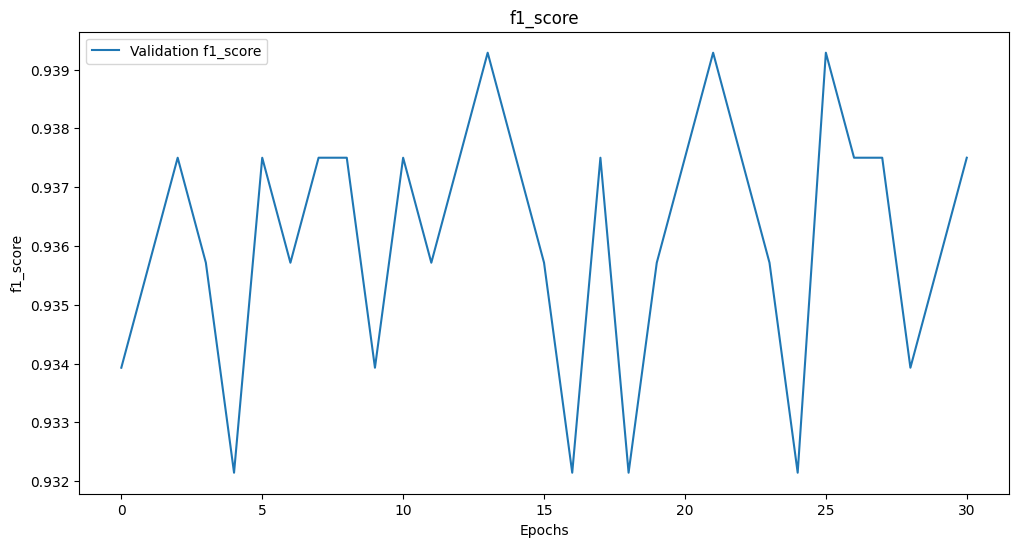

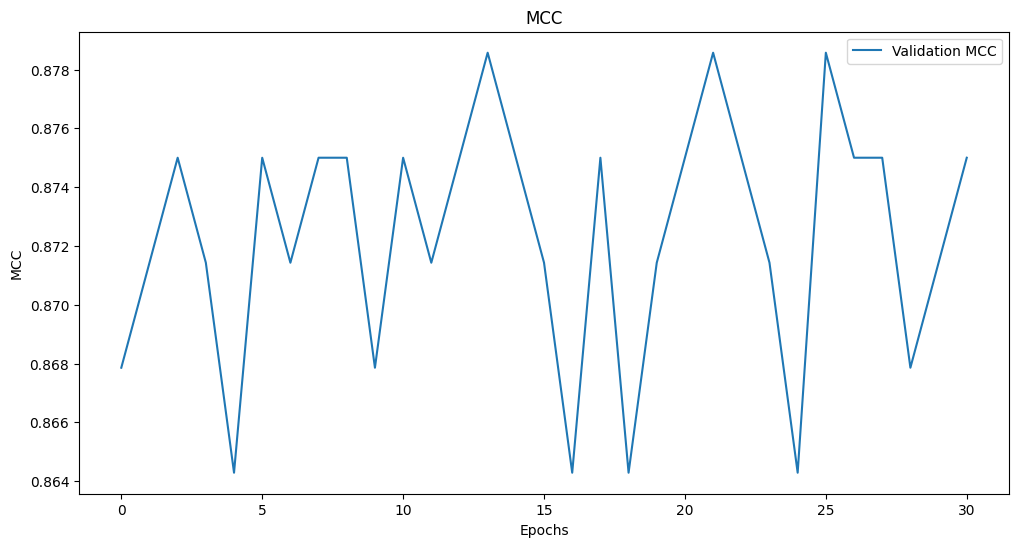

In [80]:
display_result(history_fine_tune_L2)

In [81]:
print_result()

18/18 [==============================] - 1s 39ms/step - loss: 0.1817 - accuracy: 0.9325 - mcc: 0.8715 - precision: 0.9358 - recall: 0.9358 - specificity: 0.9358 - f1_score: 0.9358 - auc: 0.9734
Validation Loss: 0.18167217075824738
Validation Accuracy: 0.9324817657470703
Validation precision: 0.8715277910232544
Validation recall: 0.9357638955116272
Validation specificity: 0.9357638955116272
Validation f1_score: 0.9357638955116272
Validation AUC: 0.9357638955116272
Validation MCC: 0.9734435677528381


18/18 [==============================] - 2s 37ms/step


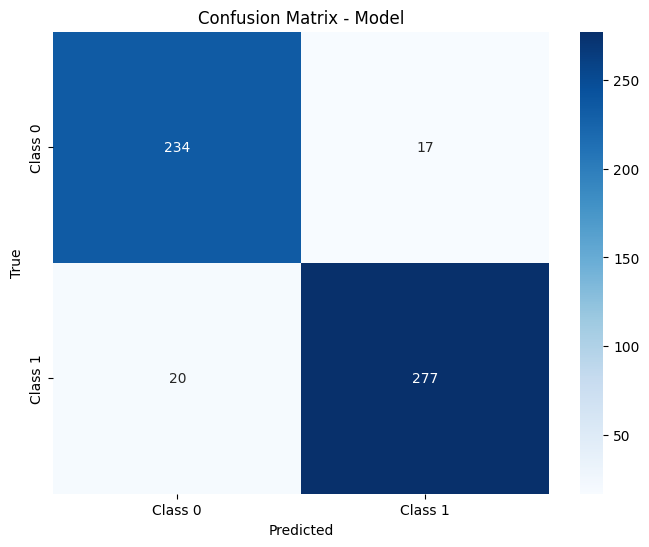

18/18 [==============================] - 1s 36ms/step


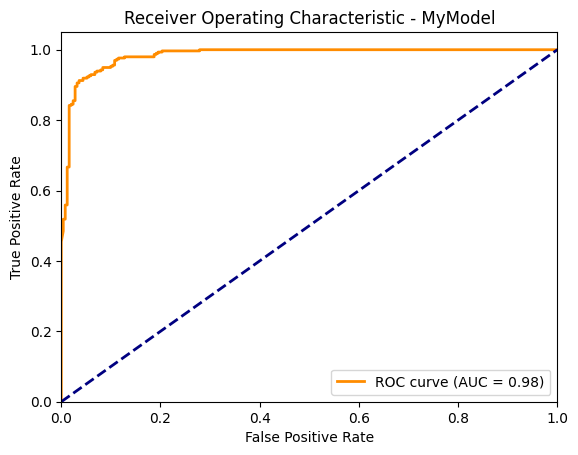

In [82]:
# Making predictions on the validation set
y_pred_probabilities = model_base.predict(X_val)

# Converting predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Converting true labels to class labels if they are one-hot encoded
y_true_classes = np.argmax(y_val, axis=1)

# Ploting the confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes)

plot_roc_auc(model_base, X_val, y_val, model_name="MyModel")

# **Fine-tuning ResNet50: Unfreezing the last 3 layers**

In [83]:
# Unfreeze last 3 layers
for layer in model_base.layers[-3:]:
    layer.trainable = True

model_base.compile(optimizer=Adam(learning_rate=1e-6), loss='binary_crossentropy', metrics=['accuracy', mcc, precision,
        recall,
        specificity,
        f1_score,
        AUC(name='auc')])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_L3.keras', monitor='val_loss', mode='min', save_best_only=True)

#  Model Training
history_fine_tune_L3 = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
274/274 [==============================] - 14s 34ms/step - loss: 0.0057 - accuracy: 1.0000 - mcc: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity: 1.0000 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.1812 - val_accuracy: 0.9343 - val_mcc: 0.8696 - val_precision: 0.9348 - val_recall: 0.9348 - val_specificity: 0.9348 - val_f1_score: 0.9348 - val_auc: 0.9733
Epoch 2/100
274/274 [==============================] - 5s 19ms/step - loss: 0.0050 - accuracy: 1.0000 - mcc: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity: 1.0000 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.1817 - val_accuracy: 0.9343 - val_mcc: 0.8696 - val_precision: 0.9348 - val_recall: 0.9348 - val_specificity: 0.9348 - val_f1_score: 0.9348 - val_auc: 0.9733
Epoch 3/100
274/274 [==============================] - 5s 19ms/step - loss: 0.0054 - accuracy: 1.0000 - mcc: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity: 1.0000 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.1815 - val_accura

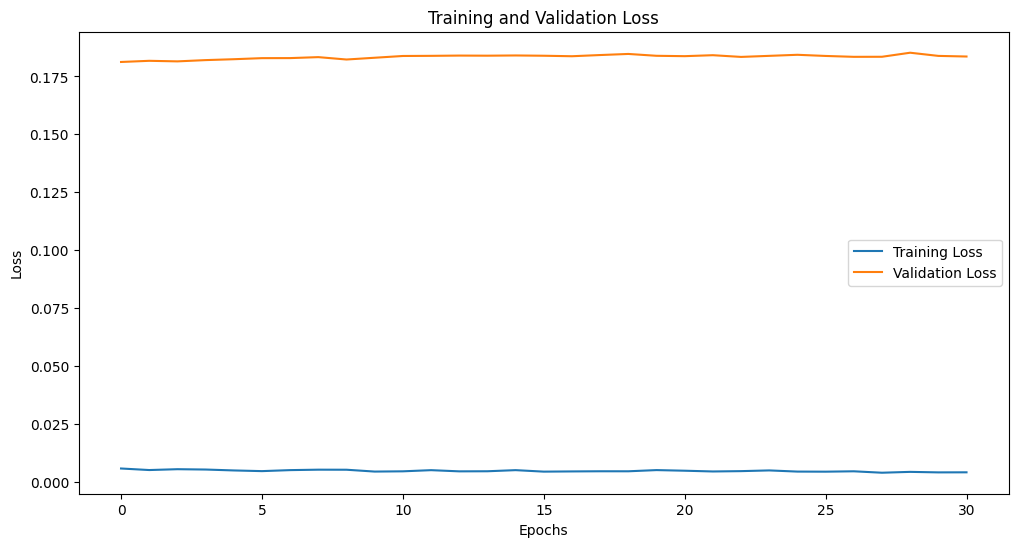

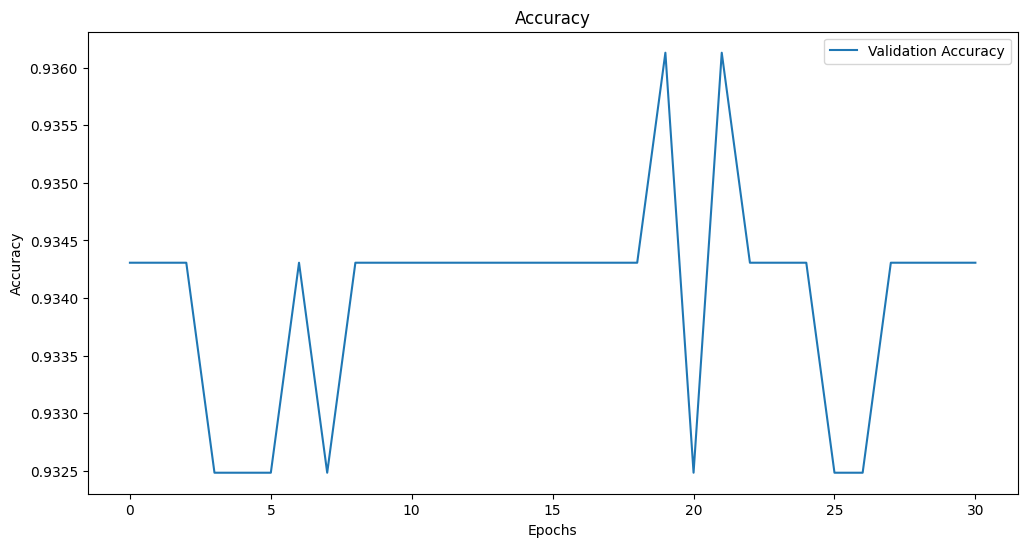

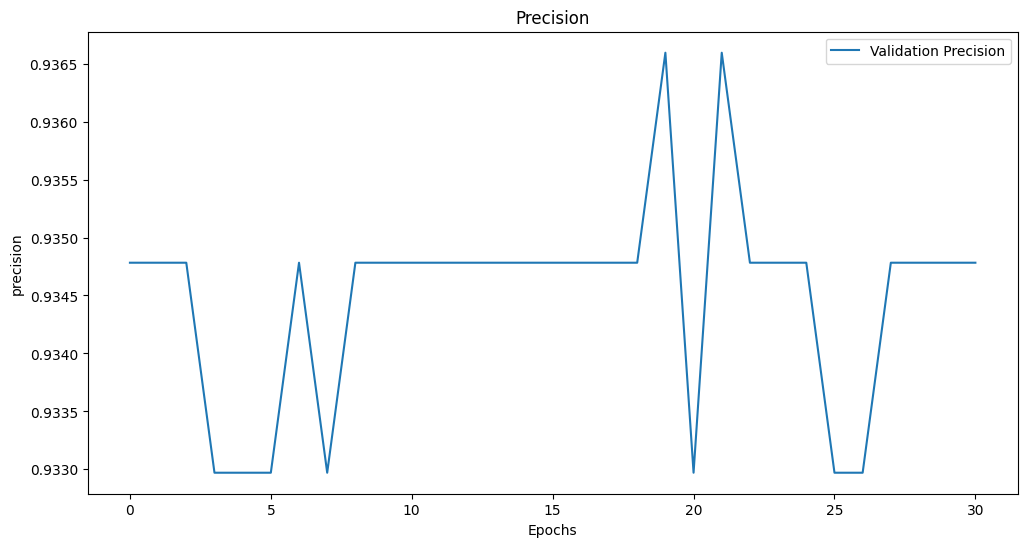

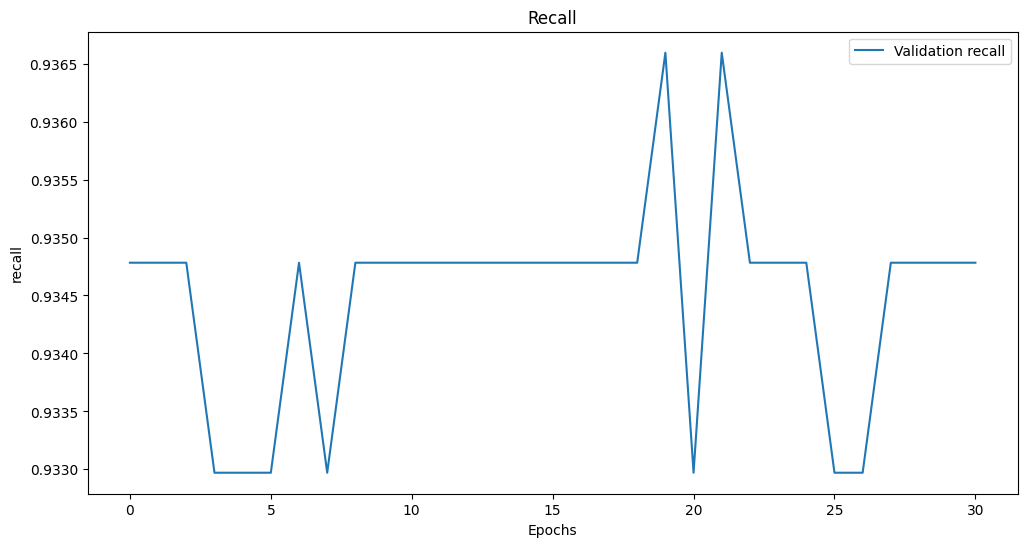

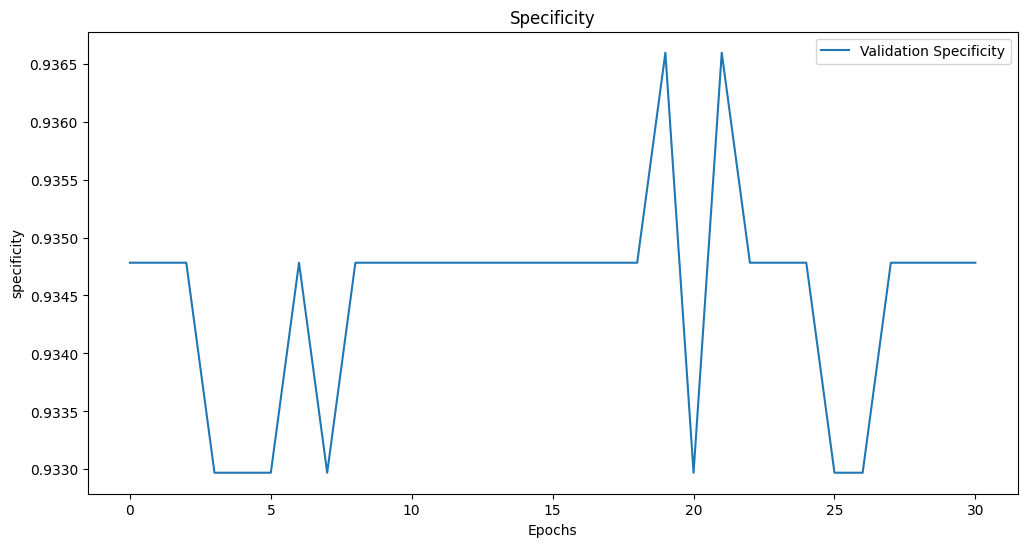

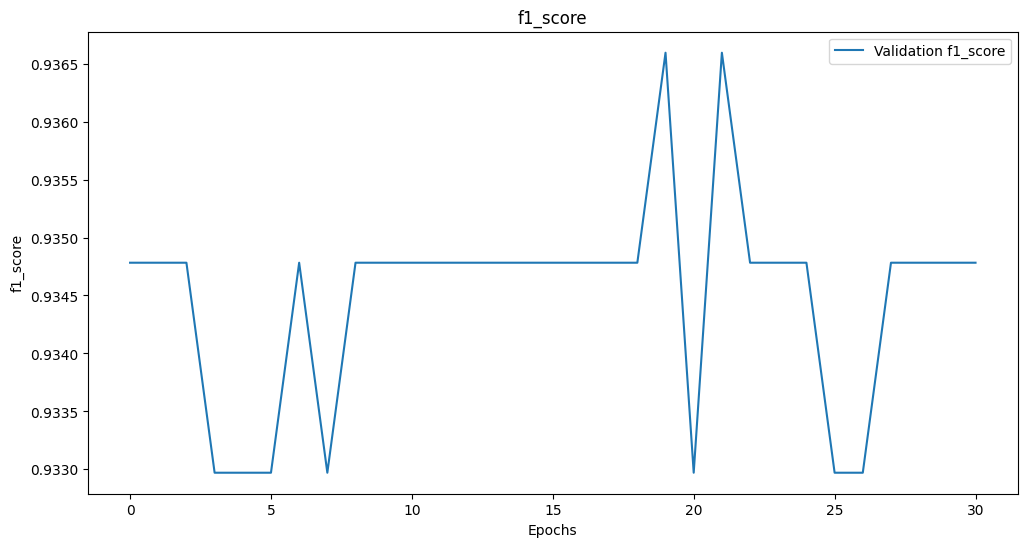

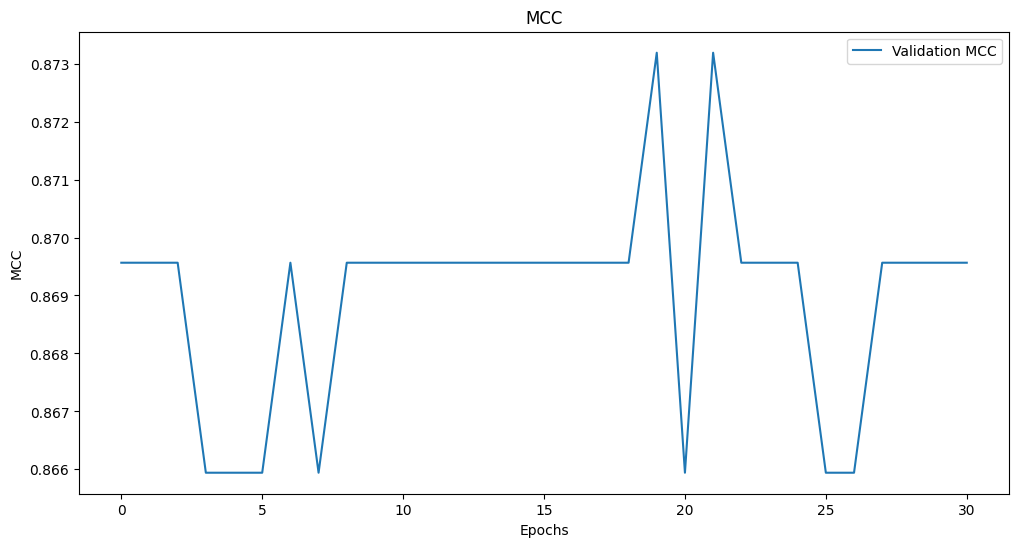

In [84]:
display_result(history_fine_tune_L3)

In [85]:
print_result()

18/18 [==============================] - 1s 39ms/step - loss: 0.1812 - accuracy: 0.9343 - mcc: 0.8750 - precision: 0.9375 - recall: 0.9375 - specificity: 0.9375 - f1_score: 0.9375 - auc: 0.9733
Validation Loss: 0.18121768534183502
Validation Accuracy: 0.9343065619468689
Validation precision: 0.875
Validation recall: 0.9375
Validation specificity: 0.9375
Validation f1_score: 0.9375
Validation AUC: 0.9375
Validation MCC: 0.97332364320755


18/18 [==============================] - 2s 36ms/step


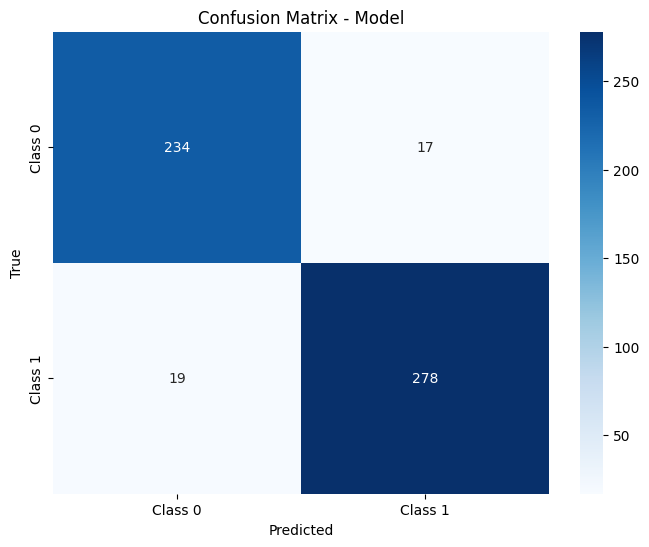

18/18 [==============================] - 1s 36ms/step


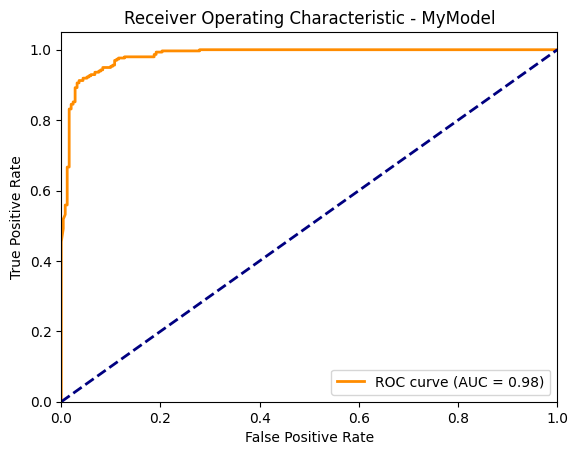

In [86]:
# Making predictions on the validation set
y_pred_probabilities = model_base.predict(X_val)

# Converting predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Converting true labels to class labels if they are one-hot encoded
y_true_classes = np.argmax(y_val, axis=1)

# Ploting the confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes)

plot_roc_auc(model_base, X_val, y_val, model_name="MyModel")

# **Fine-tuning ResNet50: Unfreezing the last 10 layers**

In [87]:
# Unfreeze top 10 layers
for layer in model_base.layers[:10]:
    layer.trainable = True

model_base.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', mcc, precision,
        recall,
        specificity,
        f1_score,
        AUC(name='auc')])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_L10.keras', monitor='val_loss', mode='min', save_best_only=True)

#  Model Training
history_fine_tune_F10 = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=8,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/100
274/274 [==============================] - 24s 60ms/step - loss: 0.5663 - accuracy: 0.8144 - mcc: 0.6277 - precision: 0.8139 - recall: 0.8139 - specificity: 0.8139 - f1_score: 0.8139 - auc: 0.8749 - val_loss: 0.3619 - val_accuracy: 0.8577 - val_mcc: 0.7174 - val_precision: 0.8587 - val_recall: 0.8587 - val_specificity: 0.8587 - val_f1_score: 0.8587 - val_auc: 0.9223
Epoch 2/100
274/274 [==============================] - 10s 35ms/step - loss: 0.4303 - accuracy: 0.8368 - mcc: 0.6743 - precision: 0.8371 - recall: 0.8371 - specificity: 0.8371 - f1_score: 0.8371 - auc: 0.9075 - val_loss: 0.3799 - val_accuracy: 0.8540 - val_mcc: 0.7101 - val_precision: 0.8551 - val_recall: 0.8551 - val_specificity: 0.8551 - val_f1_score: 0.8551 - val_auc: 0.9140
Epoch 3/100
274/274 [==============================] - 11s 40ms/step - loss: 0.3276 - accuracy: 0.8675 - mcc: 0.7354 - precision: 0.8677 - recall: 0.8677 - specificity: 0.8677 - f1_score: 0.8677 - auc: 0.9322 - val_loss: 0.3474 - val_accu

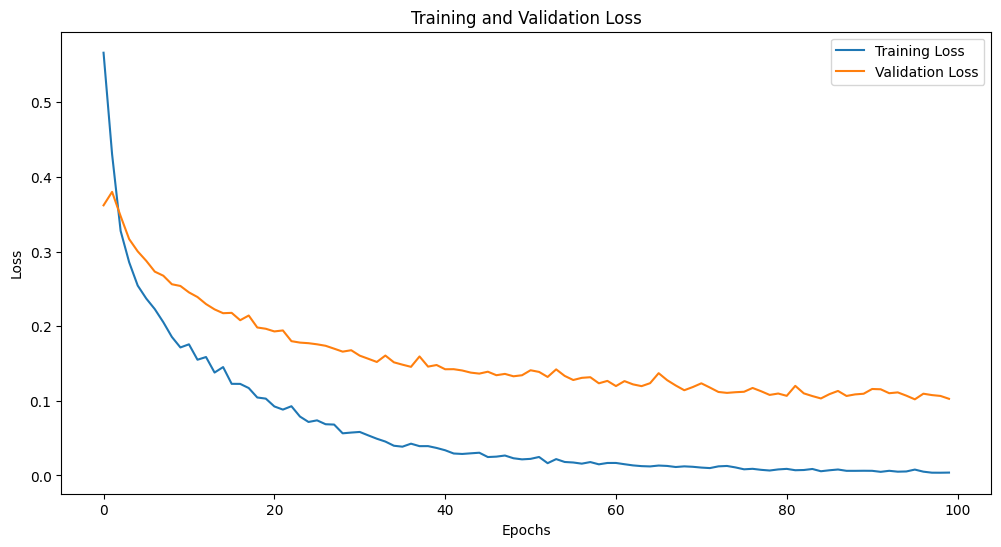

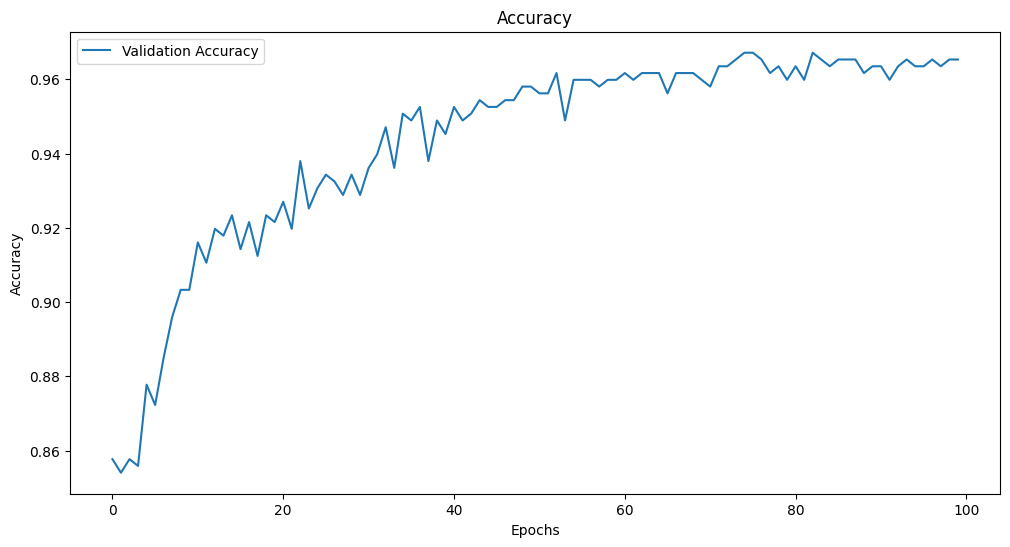

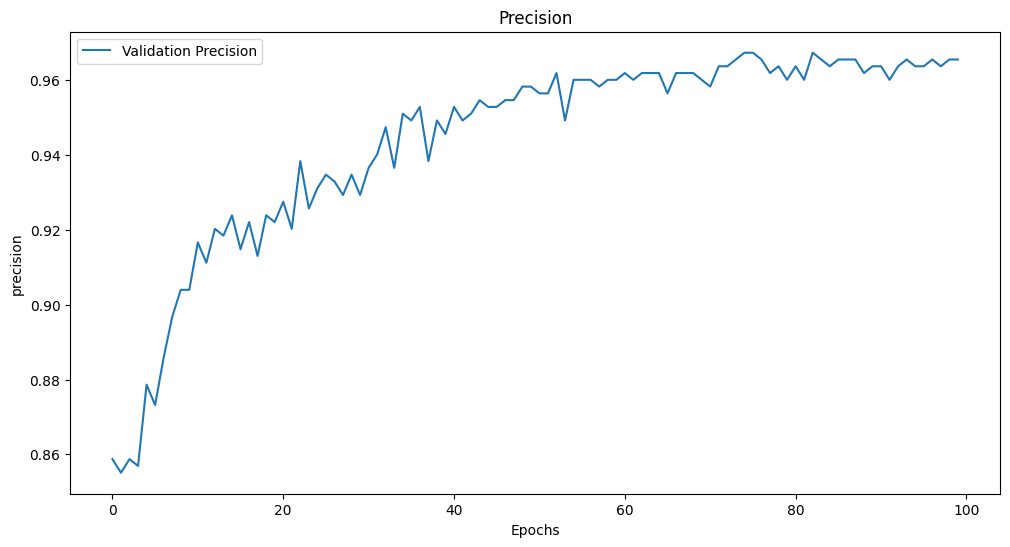

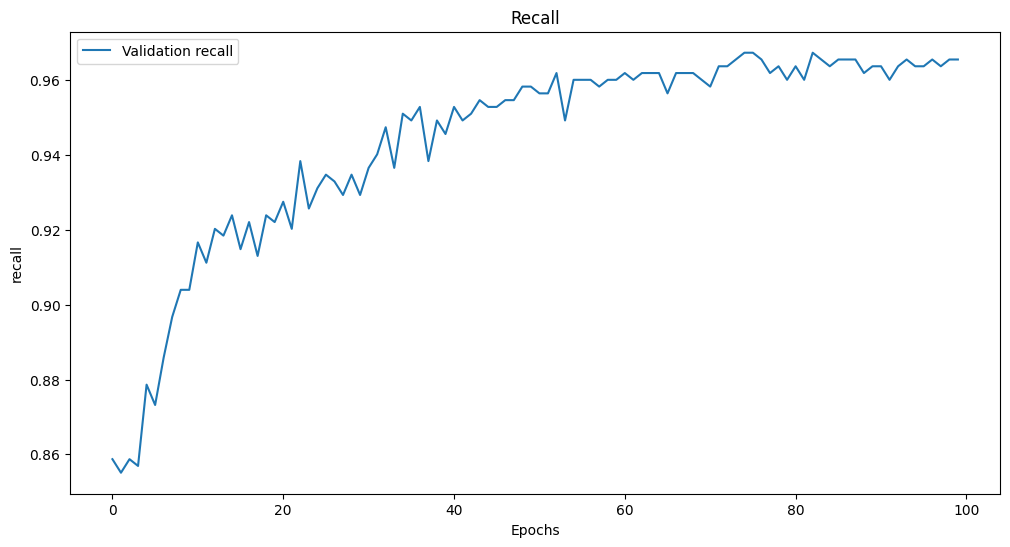

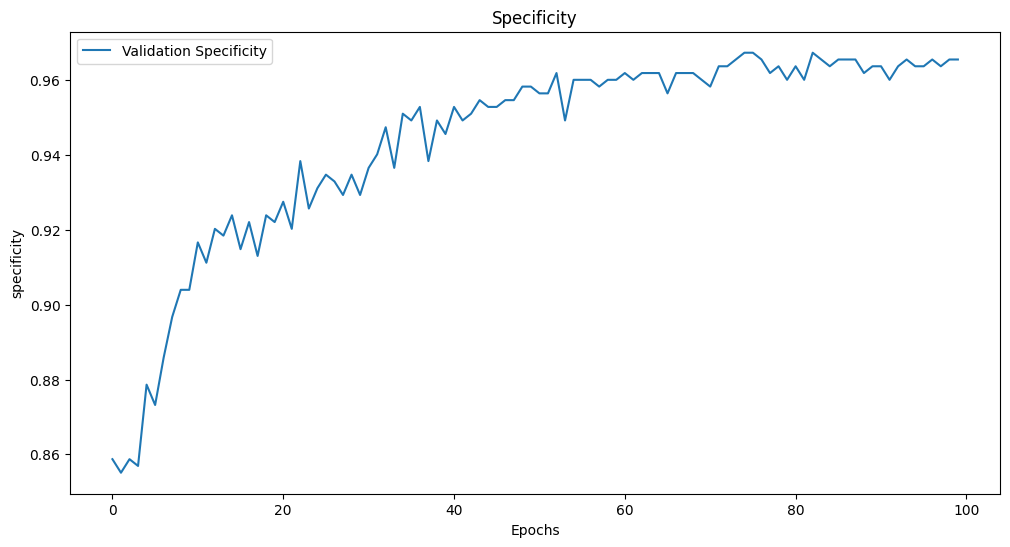

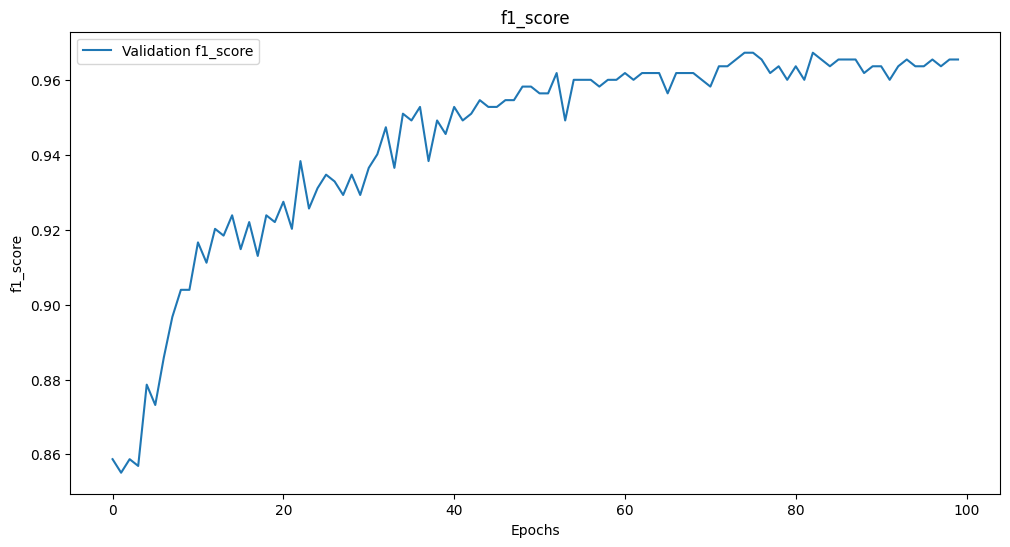

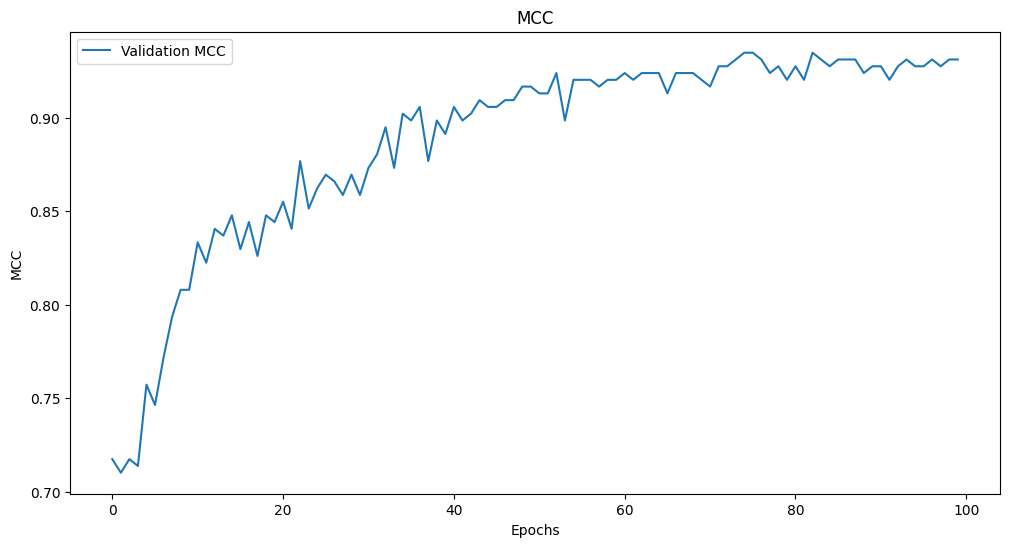

In [88]:
display_result(history_fine_tune_F10)

In [89]:
print_result()

18/18 [==============================] - 1s 38ms/step - loss: 0.1027 - accuracy: 0.9653 - mcc: 0.9340 - precision: 0.9670 - recall: 0.9670 - specificity: 0.9670 - f1_score: 0.9670 - auc: 0.9869
Validation Loss: 0.10265425592660904
Validation Accuracy: 0.9653284549713135
Validation precision: 0.9340277910232544
Validation recall: 0.9670138955116272
Validation specificity: 0.9670138955116272
Validation f1_score: 0.9670138955116272
Validation AUC: 0.9670138955116272
Validation MCC: 0.9869481921195984


18/18 [==============================] - 2s 36ms/step


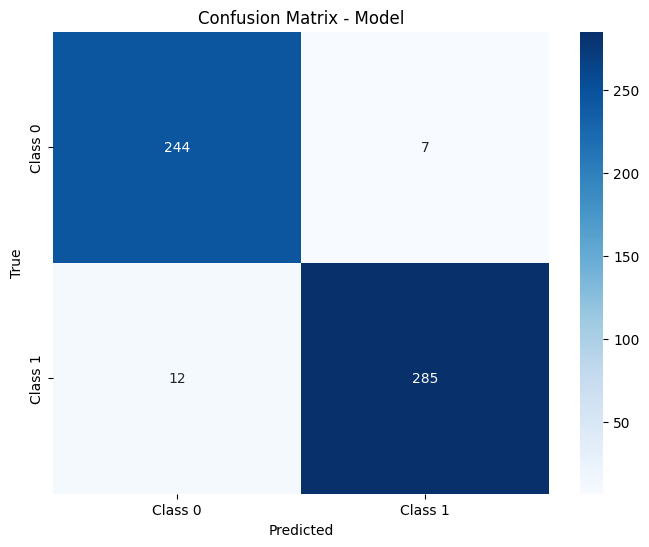

18/18 [==============================] - 1s 36ms/step


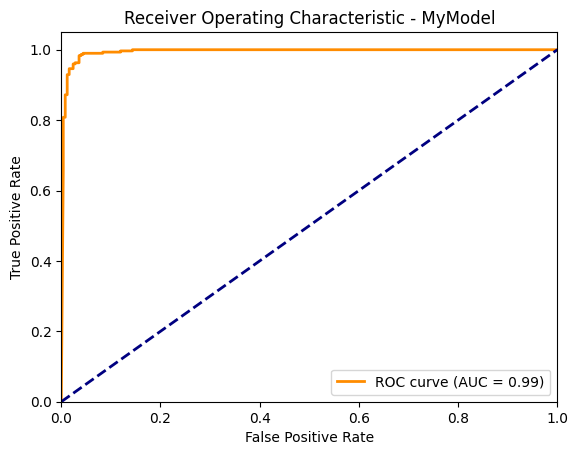

In [90]:
# Making predictions on the validation set
y_pred_probabilities = model_base.predict(X_val)

# Converting predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Converting true labels to class labels if they are one-hot encoded
y_true_classes = np.argmax(y_val, axis=1)

# Ploting the confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes)

plot_roc_auc(model_base, X_val, y_val, model_name="MyModel")

# **Fine-tuning ResNet50: Unfreezing the first 20 layers**

In [91]:
# Unfreeze first 20 layers
for layer in model_base.layers[:20]:
    layer.trainable = True

model_base.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', mcc, precision,
        recall,
        specificity,
        f1_score,
        AUC(name='auc')])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_L20.keras', monitor='val_loss', mode='min', save_best_only=True)

#  Model Training
history_fine_tune_F20 = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=8,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/150
274/274 [==============================] - 22s 54ms/step - loss: 0.4205 - accuracy: 0.8835 - mcc: 0.7655 - precision: 0.8828 - recall: 0.8828 - specificity: 0.8828 - f1_score: 0.8828 - auc: 0.9262 - val_loss: 0.4059 - val_accuracy: 0.8887 - val_mcc: 0.7790 - val_precision: 0.8895 - val_recall: 0.8895 - val_specificity: 0.8895 - val_f1_score: 0.8895 - val_auc: 0.9342
Epoch 2/150
274/274 [==============================] - 11s 41ms/step - loss: 0.2531 - accuracy: 0.9186 - mcc: 0.8367 - precision: 0.9183 - recall: 0.9183 - specificity: 0.9183 - f1_score: 0.9183 - auc: 0.9566 - val_loss: 0.3551 - val_accuracy: 0.8905 - val_mcc: 0.7826 - val_precision: 0.8913 - val_recall: 0.8913 - val_specificity: 0.8913 - val_f1_score: 0.8913 - val_auc: 0.9447
Epoch 3/150
274/274 [==============================] - 11s 41ms/step - loss: 0.1890 - accuracy: 0.9292 - mcc: 0.8586 - precision: 0.9293 - recall: 0.9293 - specificity: 0.9293 - f1_score: 0.9293 - auc: 0.9727 - val_loss: 0.3019 - val_accu

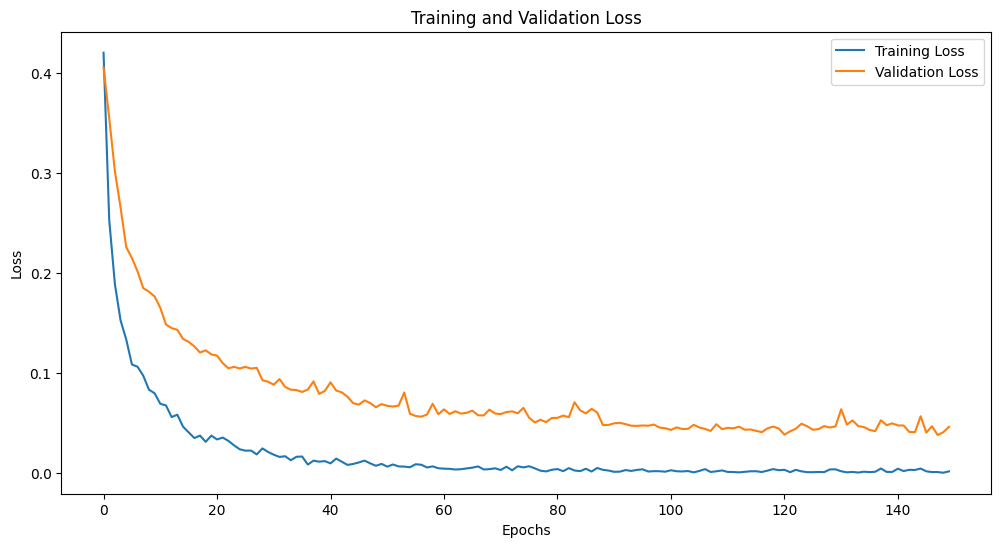

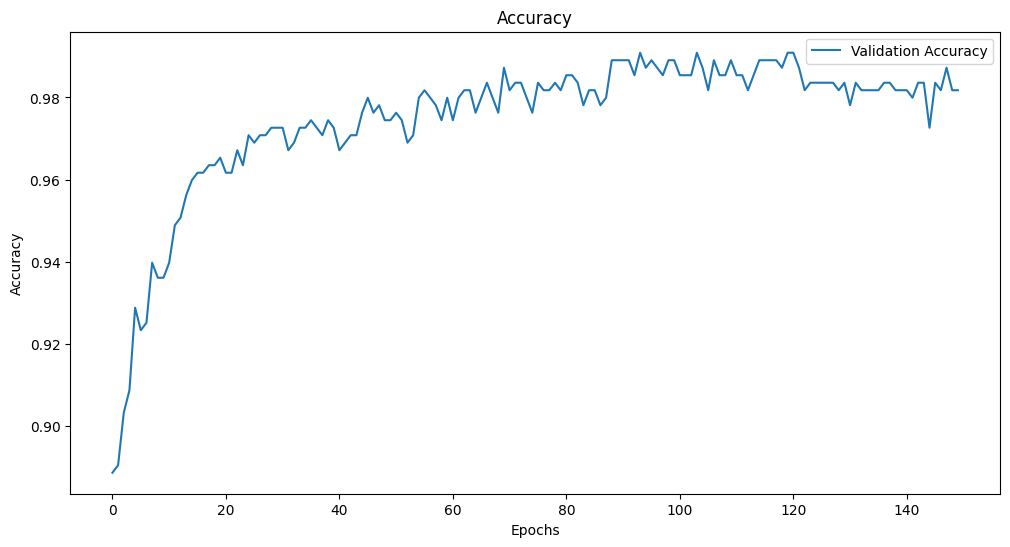

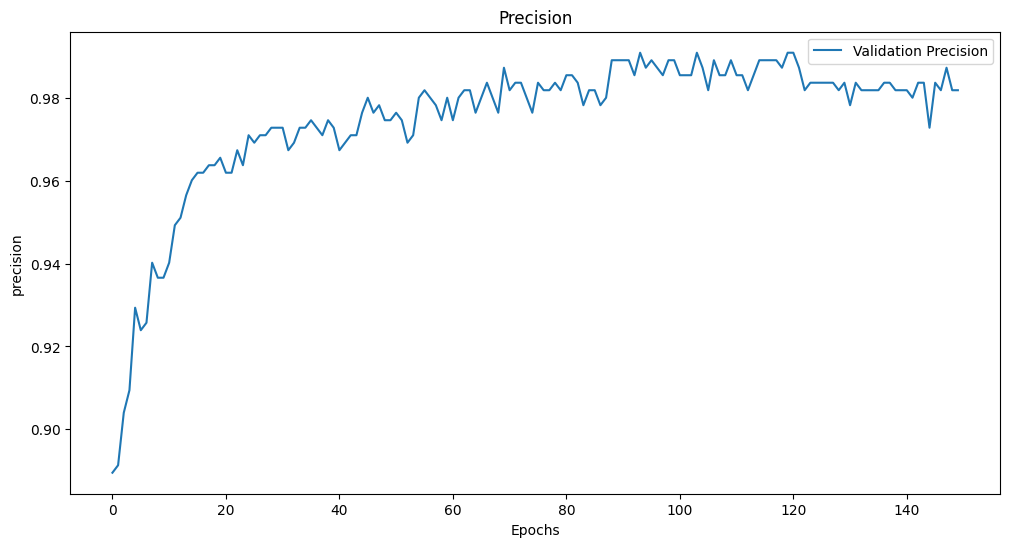

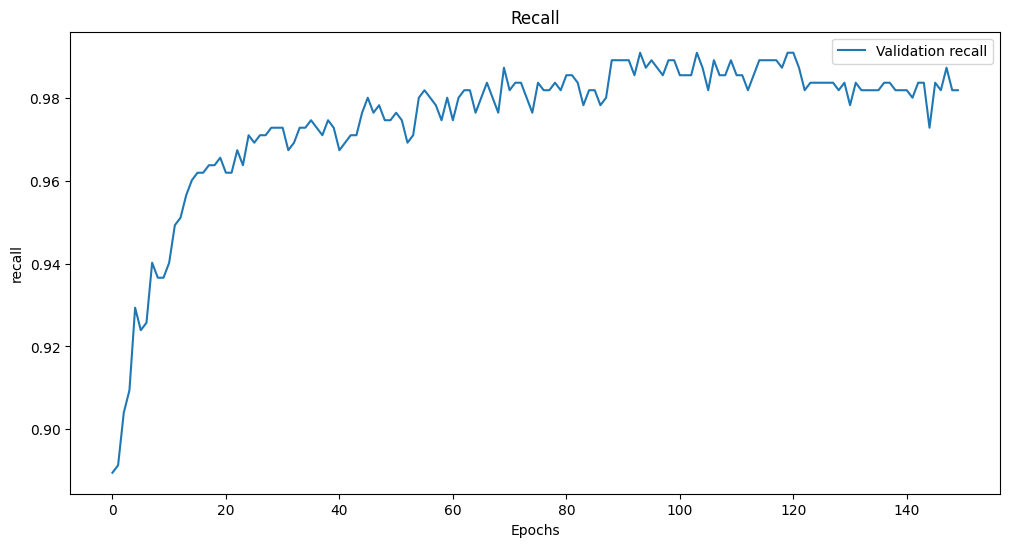

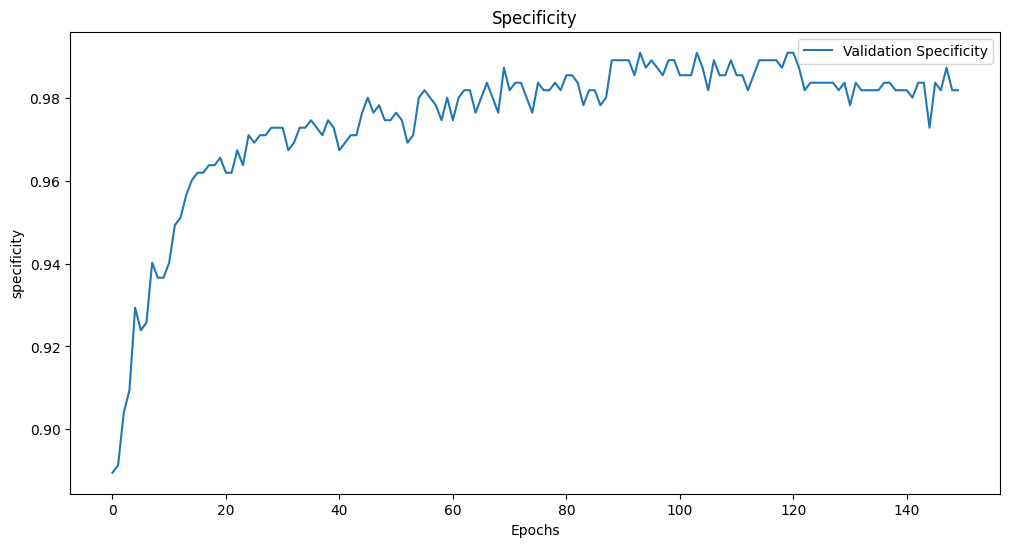

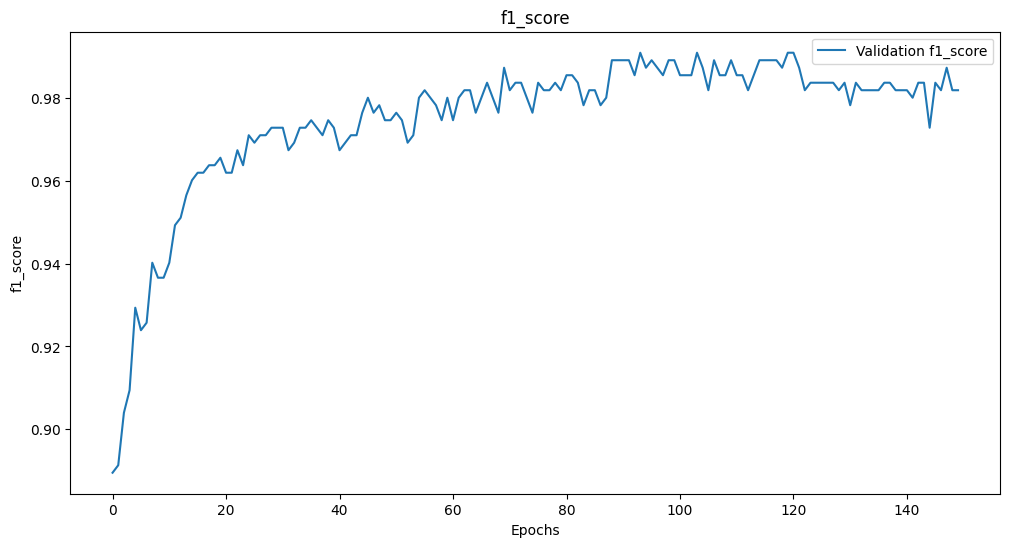

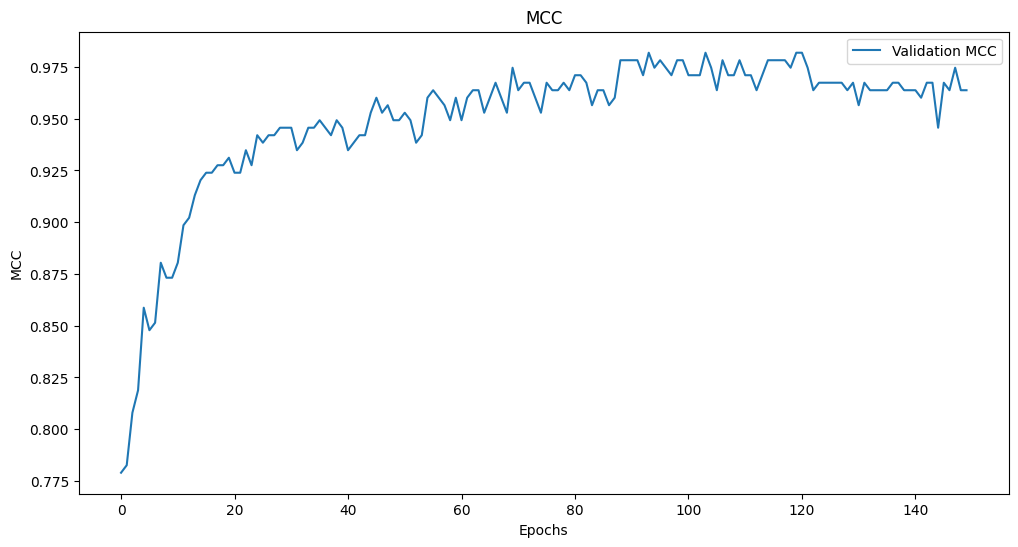

In [92]:
display_result(history_fine_tune_F20)

In [93]:
print_result()

18/18 [==============================] - 1s 39ms/step - loss: 0.0463 - accuracy: 0.9818 - mcc: 0.9653 - precision: 0.9826 - recall: 0.9826 - specificity: 0.9826 - f1_score: 0.9826 - auc: 0.9976
Validation Loss: 0.046273499727249146
Validation Accuracy: 0.9817517995834351
Validation precision: 0.9652777910232544
Validation recall: 0.9826388955116272
Validation specificity: 0.9826388955116272
Validation f1_score: 0.9826388955116272
Validation AUC: 0.9826388955116272
Validation MCC: 0.9976357817649841


18/18 [==============================] - 2s 36ms/step


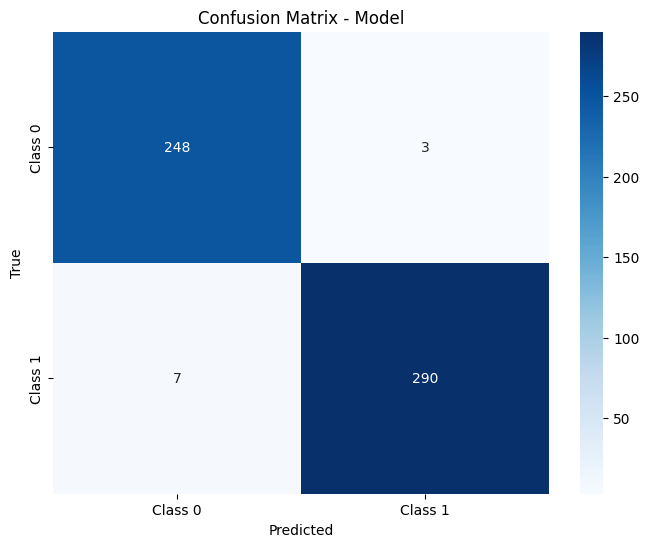

18/18 [==============================] - 1s 37ms/step


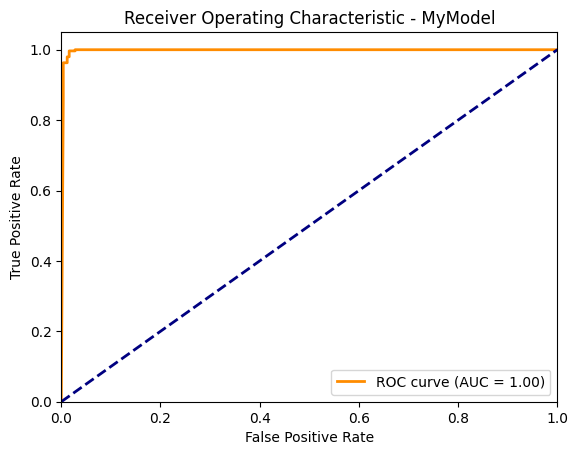

F1 Score: 0.9830508232116699


In [94]:
# Making predictions on the validation set
y_pred_probabilities = model_base.predict(X_val)

# Converting predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Converting true labels to class labels if they are one-hot encoded
y_true_classes = np.argmax(y_val, axis=1)

# Ploting the confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes)

plot_roc_auc(model_base, X_val, y_val, model_name="MyModel")

f1 = f1_score(y_true_classes, y_pred_classes)
print(f'F1 Score: {f1}')


In [95]:
# Unfreeze first 30 layers
for layer in model_base.layers[:5]:
    layer.trainable = True
for layer in model_base.layers[-5:]:
    layer.trainable = True

model_base.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', mcc, precision,
        recall,
        specificity,
        f1_score,
        AUC(name='auc')])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_F30.keras', monitor='val_loss', mode='min', save_best_only=True)

#  Model Training
history_fine_tune_F30 = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=8,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/150
274/274 [==============================] - 21s 50ms/step - loss: 0.0015 - accuracy: 0.9995 - mcc: 0.9991 - precision: 0.9995 - recall: 0.9995 - specificity: 0.9995 - f1_score: 0.9995 - auc: 1.0000 - val_loss: 0.0453 - val_accuracy: 0.9836 - val_mcc: 0.9674 - val_precision: 0.9837 - val_recall: 0.9837 - val_specificity: 0.9837 - val_f1_score: 0.9837 - val_auc: 0.9959
Epoch 2/150
274/274 [==============================] - 11s 41ms/step - loss: 0.0013 - accuracy: 0.9995 - mcc: 0.9991 - precision: 0.9995 - recall: 0.9995 - specificity: 0.9995 - f1_score: 0.9995 - auc: 1.0000 - val_loss: 0.0436 - val_accuracy: 0.9836 - val_mcc: 0.9674 - val_precision: 0.9837 - val_recall: 0.9837 - val_specificity: 0.9837 - val_f1_score: 0.9837 - val_auc: 0.9976
Epoch 3/150
274/274 [==============================] - 10s 36ms/step - loss: 5.2541e-04 - accuracy: 1.0000 - mcc: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity: 1.0000 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0473 - val_

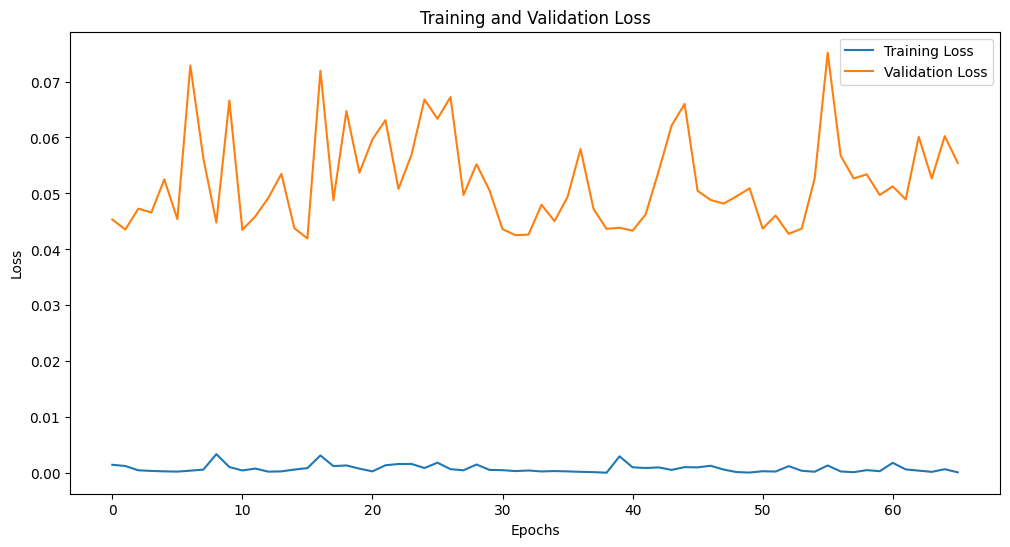

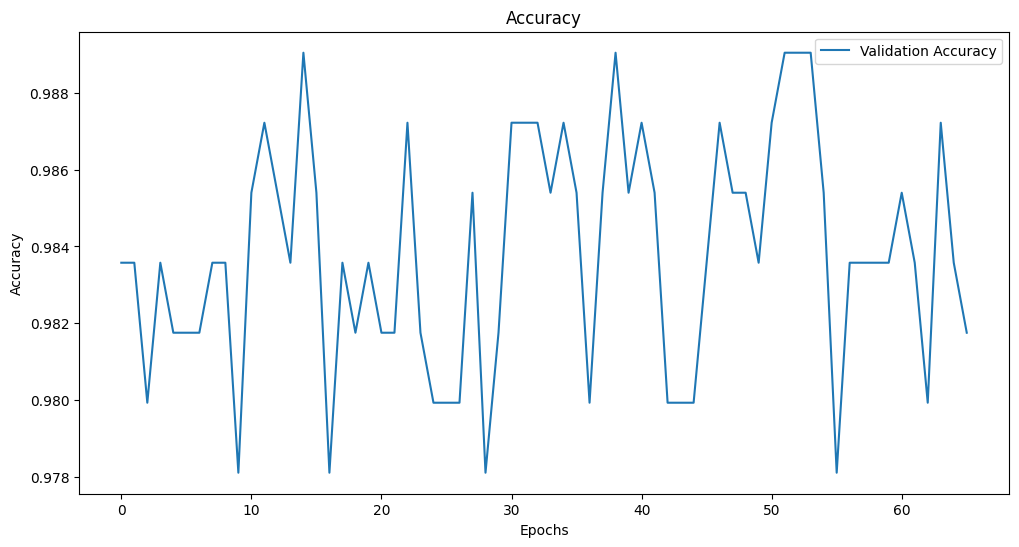

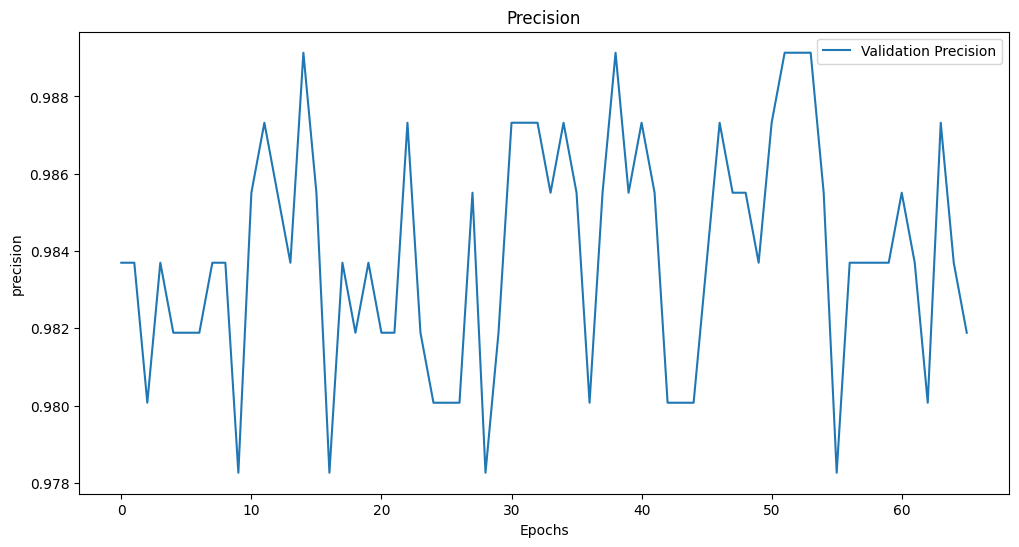

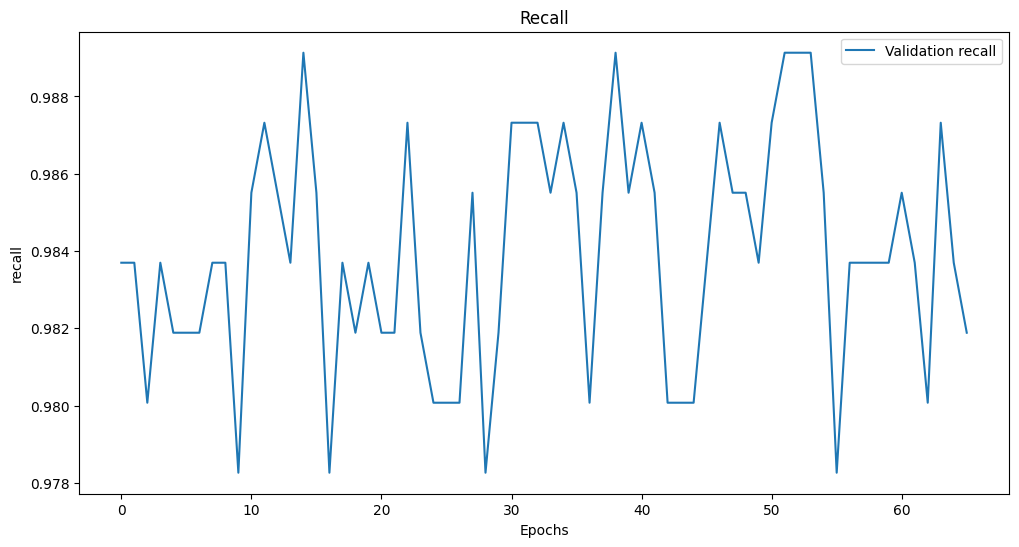

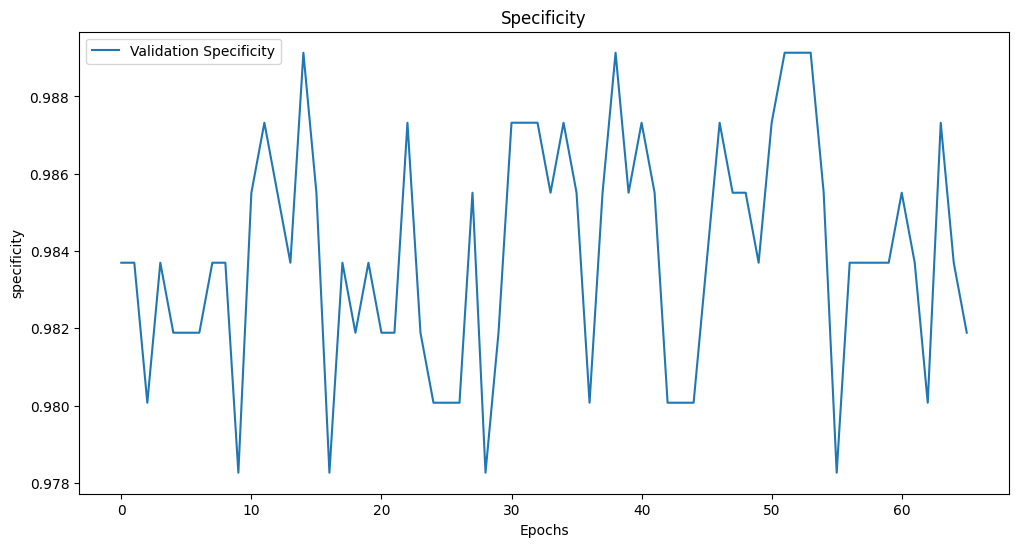

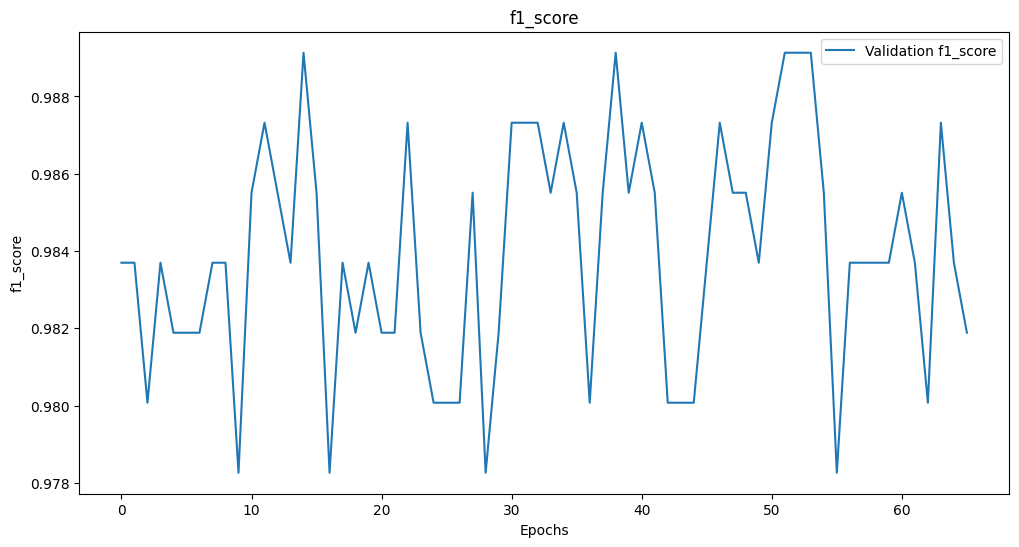

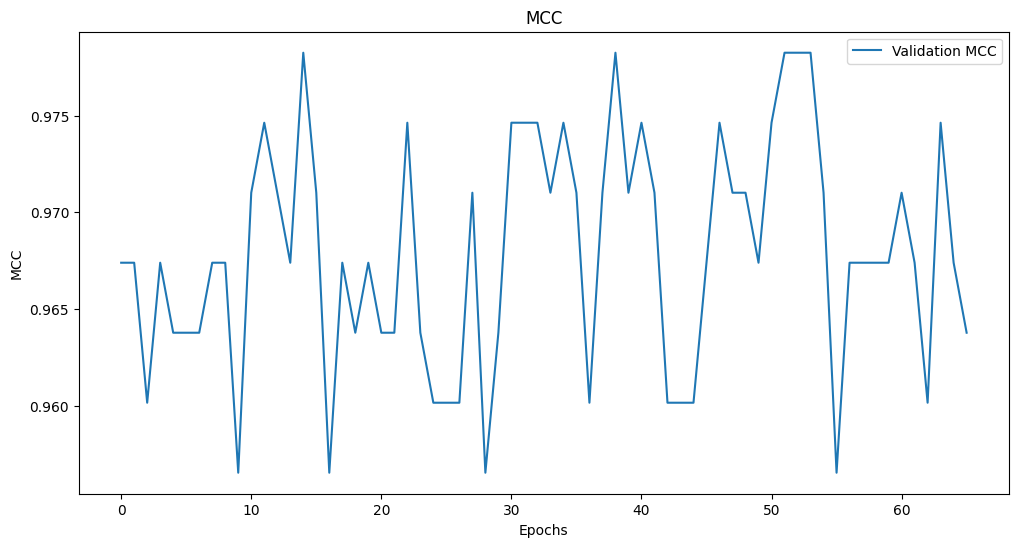

In [96]:
display_result(history_fine_tune_F30)

In [97]:
print_result()

18/18 [==============================] - 1s 39ms/step - loss: 0.0420 - accuracy: 0.9854 - mcc: 0.9722 - precision: 0.9861 - recall: 0.9861 - specificity: 0.9861 - f1_score: 0.9861 - auc: 0.9960
Validation Loss: 0.041954927146434784
Validation Accuracy: 0.985401451587677
Validation precision: 0.9722222089767456
Validation recall: 0.9861111044883728
Validation specificity: 0.9861111044883728
Validation f1_score: 0.9861111044883728
Validation AUC: 0.9861111044883728
Validation MCC: 0.9960306882858276


18/18 [==============================] - 2s 37ms/step


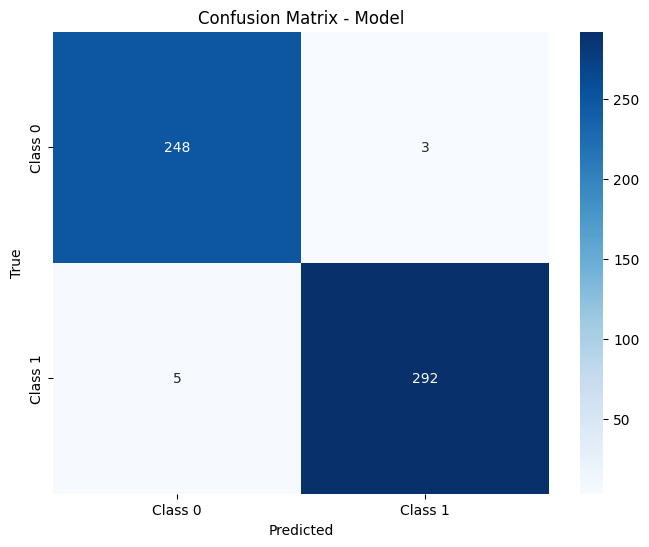

18/18 [==============================] - 1s 36ms/step


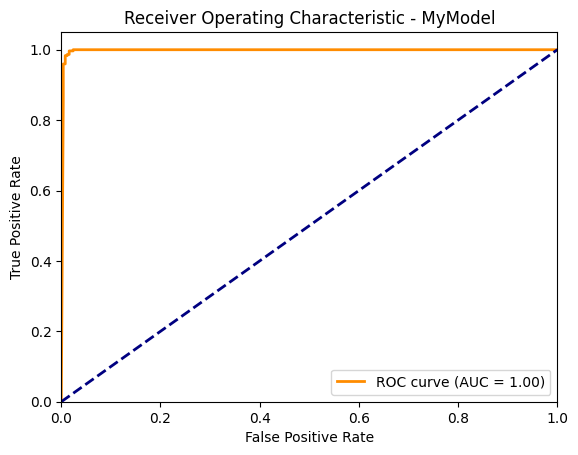

F1 Score: 0.9864863753318787


In [98]:
# Making predictions on the validation set
y_pred_probabilities = model_base.predict(X_val)

# Converting predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Converting true labels to class labels if they are one-hot encoded
y_true_classes = np.argmax(y_val, axis=1)

# Ploting the confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes)

plot_roc_auc(model_base, X_val, y_val, model_name="MyModel")

f1 = f1_score(y_true_classes, y_pred_classes)
print(f'F1 Score: {f1}')


In [99]:
# Unfreeze first 20 layers
for layer in model_base.layers[:20]:
    layer.trainable = True
for layer in model_base.layers[-1:]:
    layer.trainable = True

model_base.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', mcc, precision,
        recall,
        specificity,
        f1_score,
        AUC(name='auc')])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_L20.keras', monitor='val_loss', mode='min', save_best_only=True)

#  Model Training
history_fine_tune_F20 = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=8,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/150
274/274 [==============================] - 23s 58ms/step - loss: 5.6790e-04 - accuracy: 1.0000 - mcc: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity: 1.0000 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0504 - val_accuracy: 0.9818 - val_mcc: 0.9638 - val_precision: 0.9819 - val_recall: 0.9819 - val_specificity: 0.9819 - val_f1_score: 0.9819 - val_auc: 0.9923
Epoch 2/150
274/274 [==============================] - 11s 41ms/step - loss: 0.0011 - accuracy: 0.9991 - mcc: 0.9982 - precision: 0.9991 - recall: 0.9991 - specificity: 0.9991 - f1_score: 0.9991 - auc: 1.0000 - val_loss: 0.0454 - val_accuracy: 0.9836 - val_mcc: 0.9674 - val_precision: 0.9837 - val_recall: 0.9837 - val_specificity: 0.9837 - val_f1_score: 0.9837 - val_auc: 0.9977
Epoch 3/150
274/274 [==============================] - 10s 36ms/step - loss: 7.8871e-04 - accuracy: 0.9995 - mcc: 0.9991 - precision: 0.9995 - recall: 0.9995 - specificity: 0.9995 - f1_score: 0.9995 - auc: 1.0000 - val_loss: 0.0483 - 

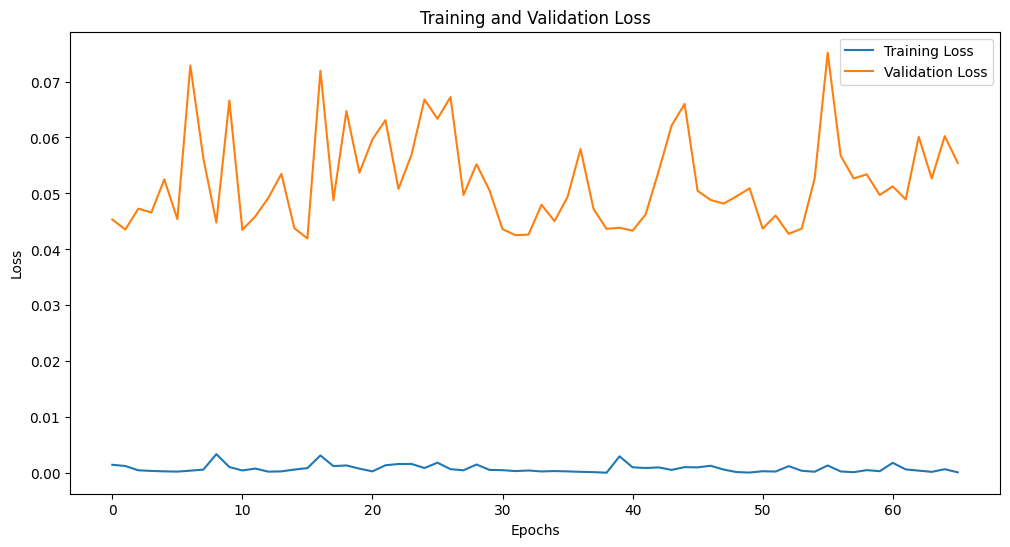

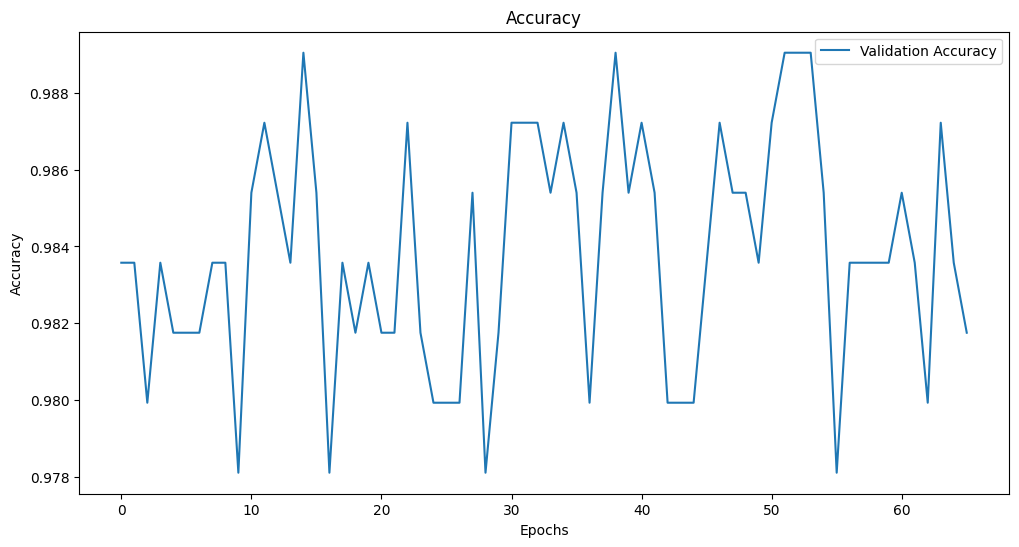

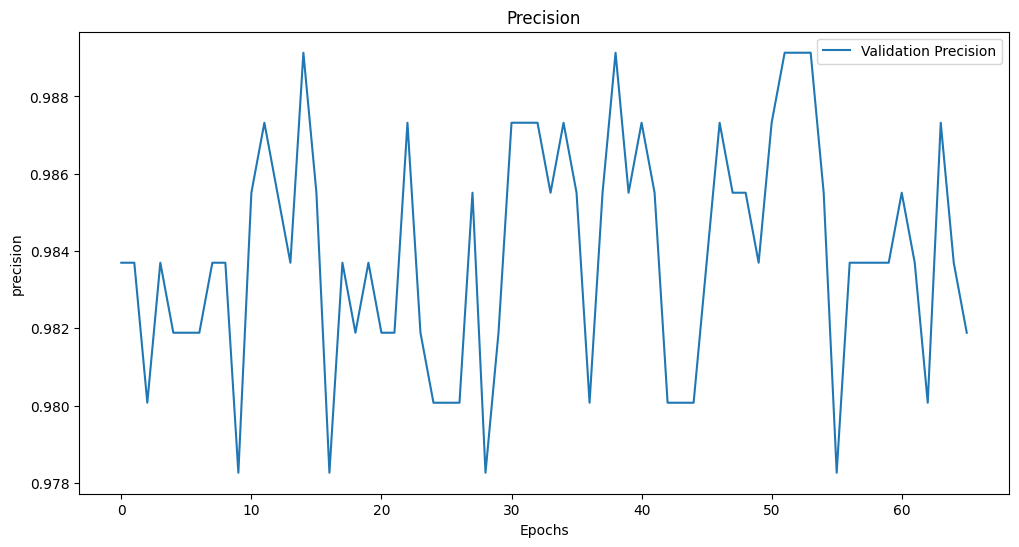

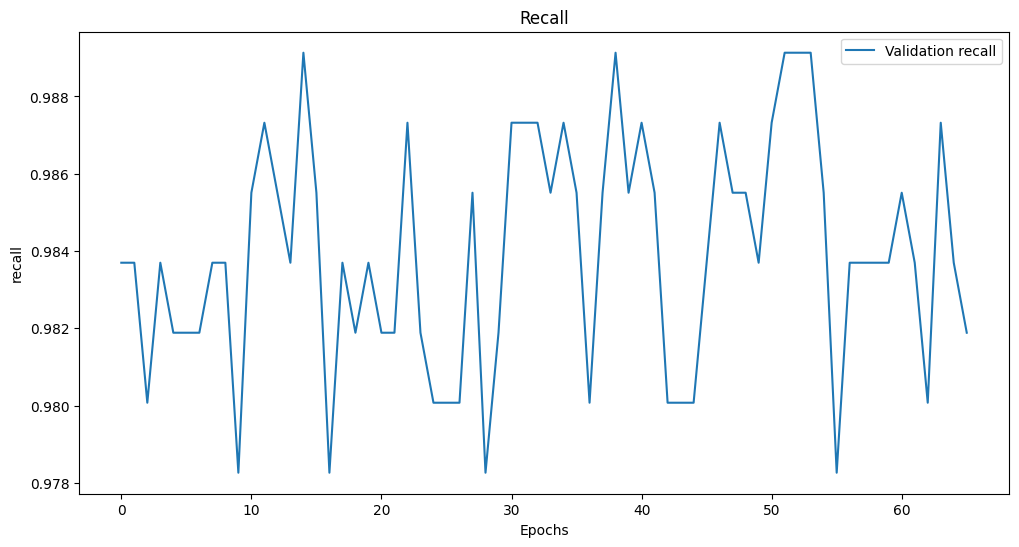

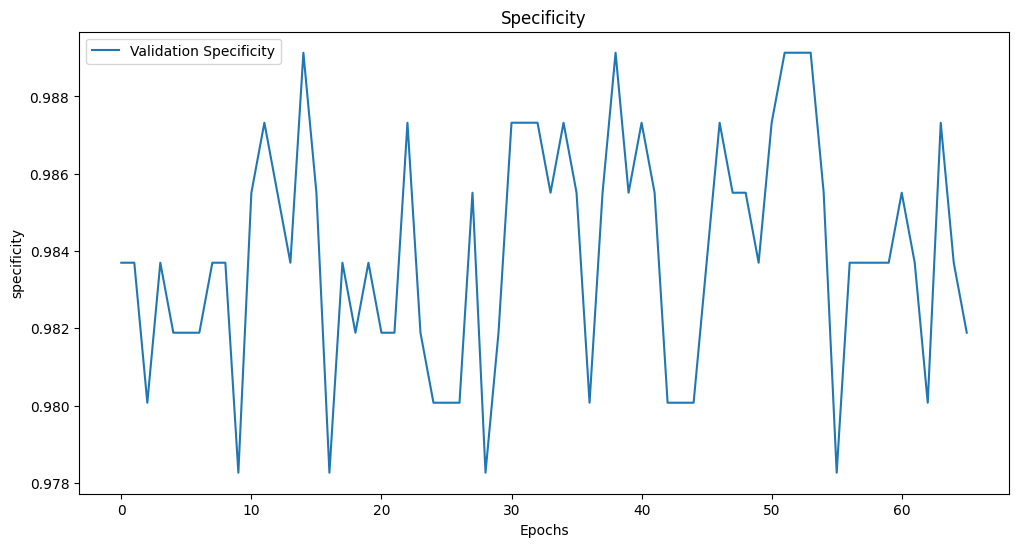

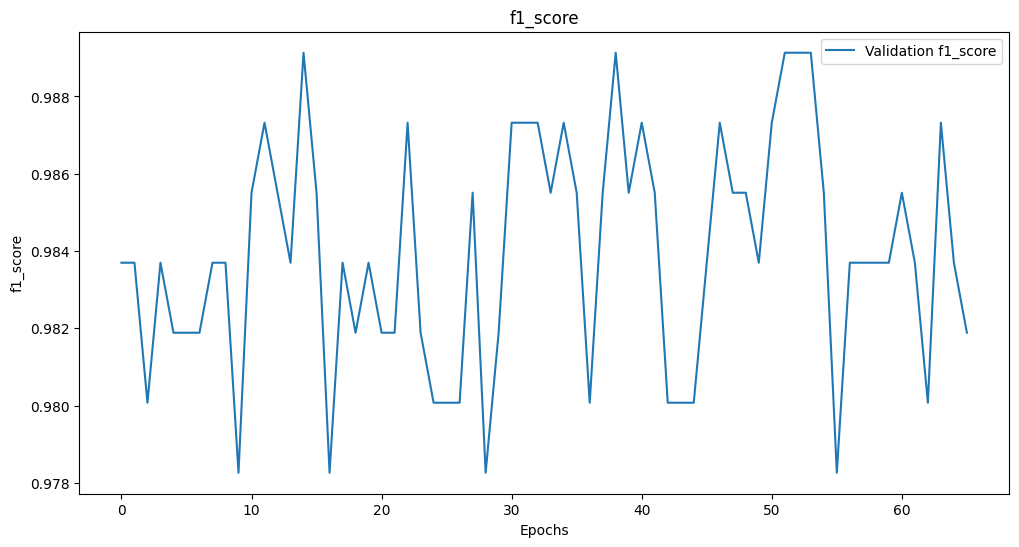

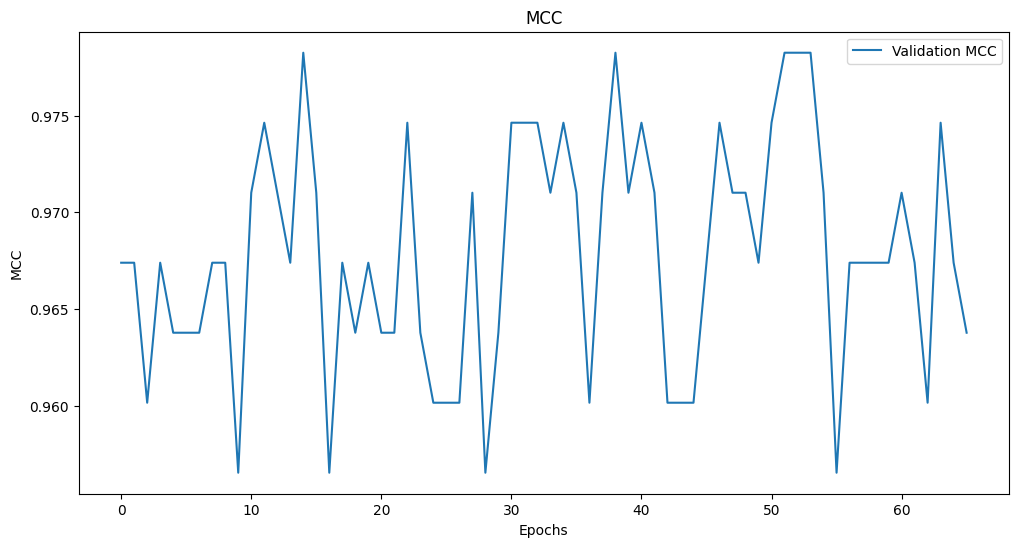

In [100]:
display_result(history_fine_tune_F30)

In [101]:
print_result()

18/18 [==============================] - 1s 39ms/step - loss: 0.0246 - accuracy: 0.9945 - mcc: 0.9896 - precision: 0.9948 - recall: 0.9948 - specificity: 0.9948 - f1_score: 0.9948 - auc: 0.9981
Validation Loss: 0.02460598386824131
Validation Accuracy: 0.9945255517959595
Validation precision: 0.9895833134651184
Validation recall: 0.9947916865348816
Validation specificity: 0.9947916865348816
Validation f1_score: 0.9947916865348816
Validation AUC: 0.9947916865348816
Validation MCC: 0.9980918765068054


18/18 [==============================] - 2s 36ms/step


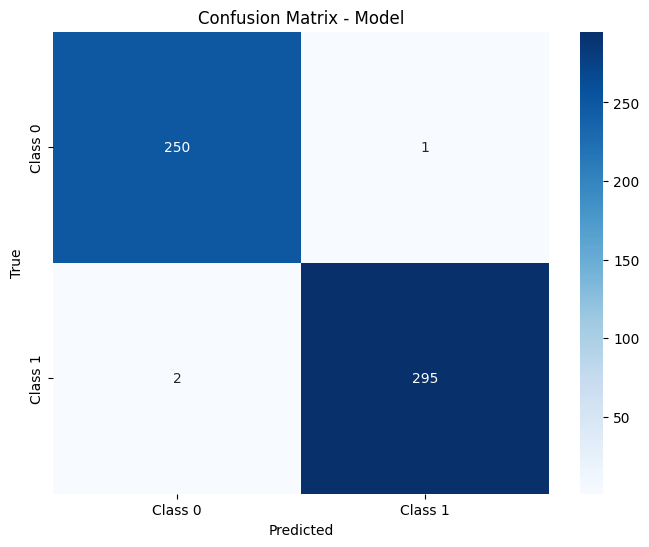

18/18 [==============================] - 1s 36ms/step


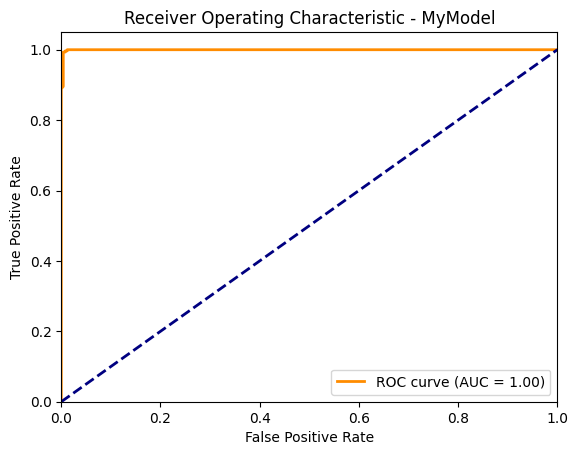

F1 Score: 0.9949409365653992


In [102]:
# Making predictions on the validation set
y_pred_probabilities = model_base.predict(X_val)

# Converting predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Converting true labels to class labels if they are one-hot encoded
y_true_classes = np.argmax(y_val, axis=1)

# Ploting the confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes)

plot_roc_auc(model_base, X_val, y_val, model_name="MyModel")

f1 = f1_score(y_true_classes, y_pred_classes)
print(f'F1 Score: {f1}')


In [103]:
# Unfreeze first 20 layers
for layer in model_base.layers[:20]:
    layer.trainable = True
for layer in model_base.layers[-1:]:
    layer.trainable = True

model_base.compile(optimizer=Adam(learning_rate=1e-5), loss='binary_crossentropy', metrics=['accuracy', mcc, precision,
        recall,
        specificity,
        f1_score,
        AUC(name='auc')])

early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=50, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model_L20.keras', monitor='val_loss', mode='min', save_best_only=True)

#  Model Training
history_fine_tune_F20 = model_base.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=8,
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/150
274/274 [==============================] - 22s 50ms/step - loss: 0.0014 - accuracy: 0.9991 - mcc: 0.9982 - precision: 0.9991 - recall: 0.9991 - specificity: 0.9991 - f1_score: 0.9991 - auc: 1.0000 - val_loss: 0.0351 - val_accuracy: 0.9872 - val_mcc: 0.9746 - val_precision: 0.9873 - val_recall: 0.9873 - val_specificity: 0.9873 - val_f1_score: 0.9873 - val_auc: 0.9978
Epoch 2/150
274/274 [==============================] - 10s 36ms/step - loss: 2.2872e-04 - accuracy: 1.0000 - mcc: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity: 1.0000 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0391 - val_accuracy: 0.9854 - val_mcc: 0.9710 - val_precision: 0.9855 - val_recall: 0.9855 - val_specificity: 0.9855 - val_f1_score: 0.9855 - val_auc: 0.9960
Epoch 3/150
274/274 [==============================] - 11s 41ms/step - loss: 1.2929e-04 - accuracy: 1.0000 - mcc: 1.0000 - precision: 1.0000 - recall: 1.0000 - specificity: 1.0000 - f1_score: 1.0000 - auc: 1.0000 - val_loss: 0.0295 - 

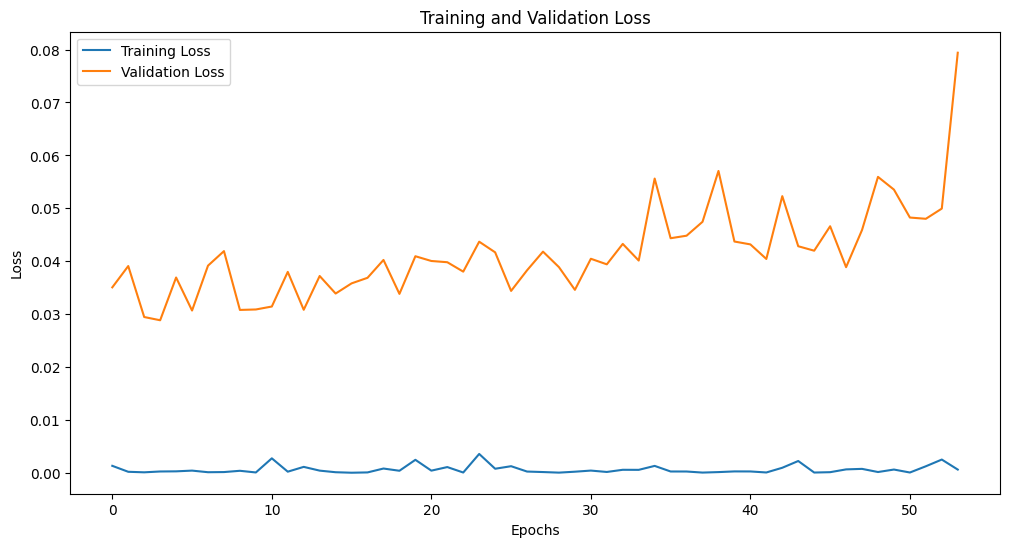

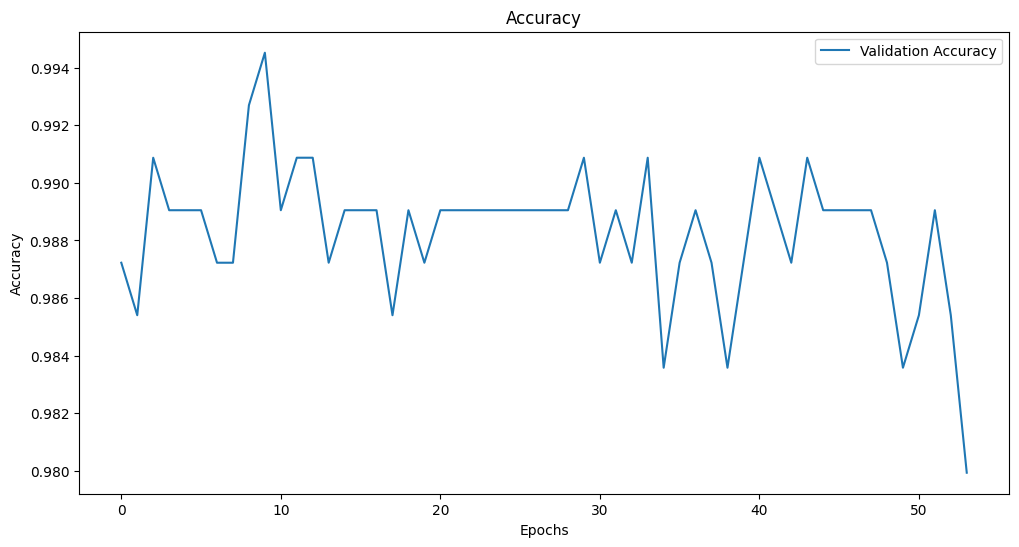

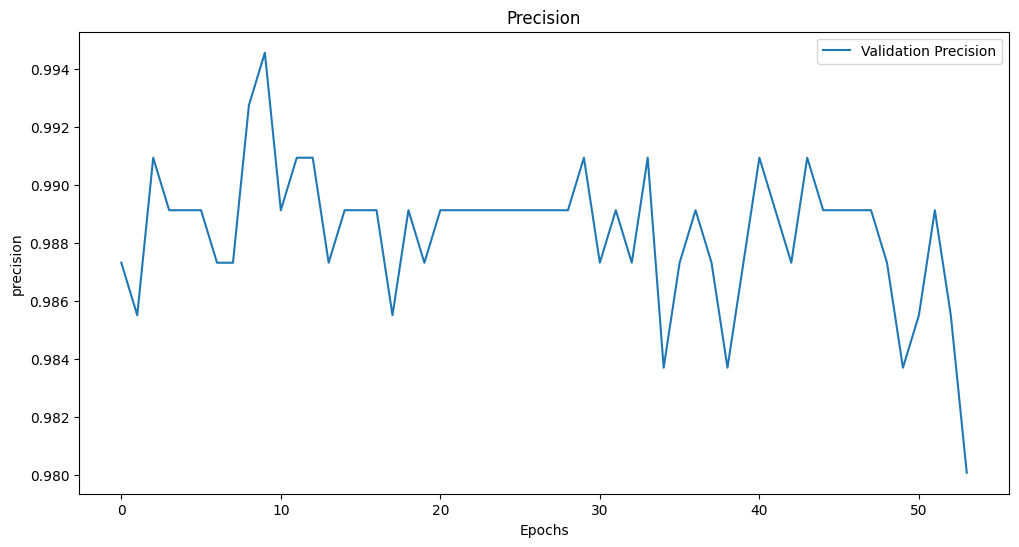

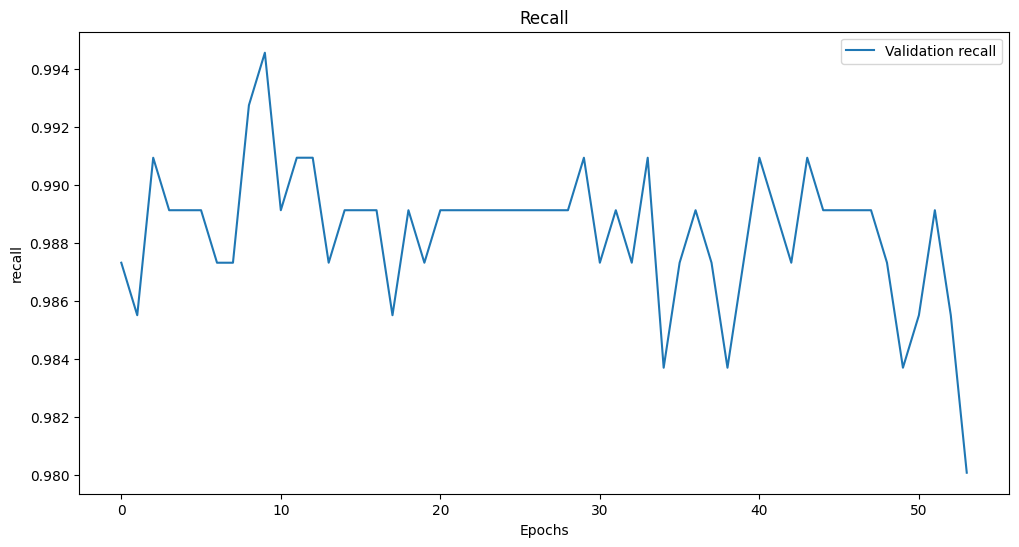

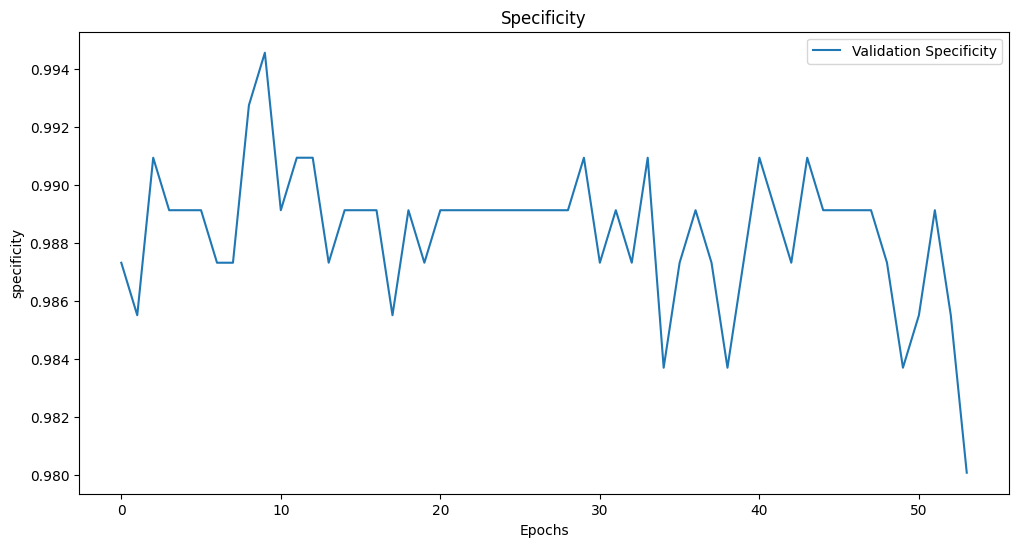

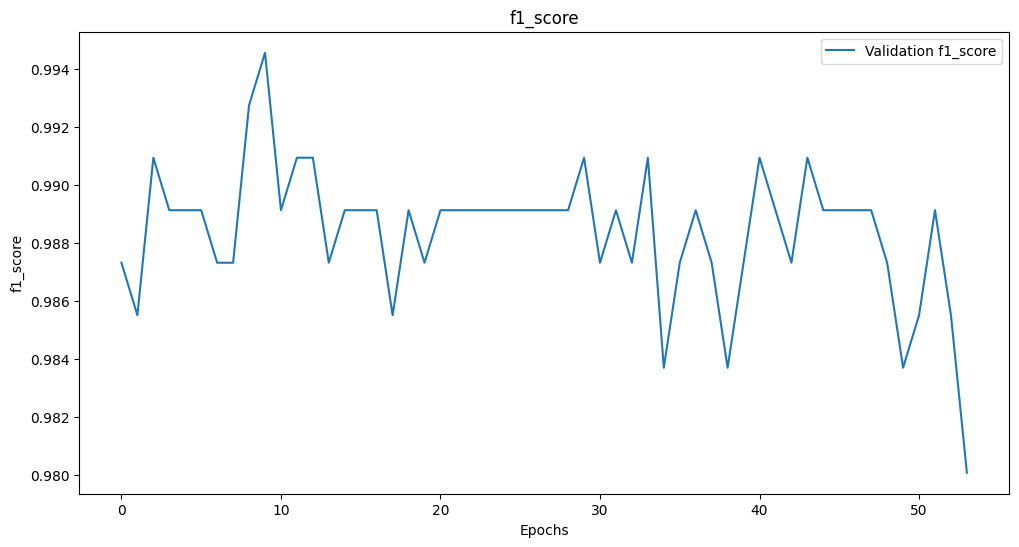

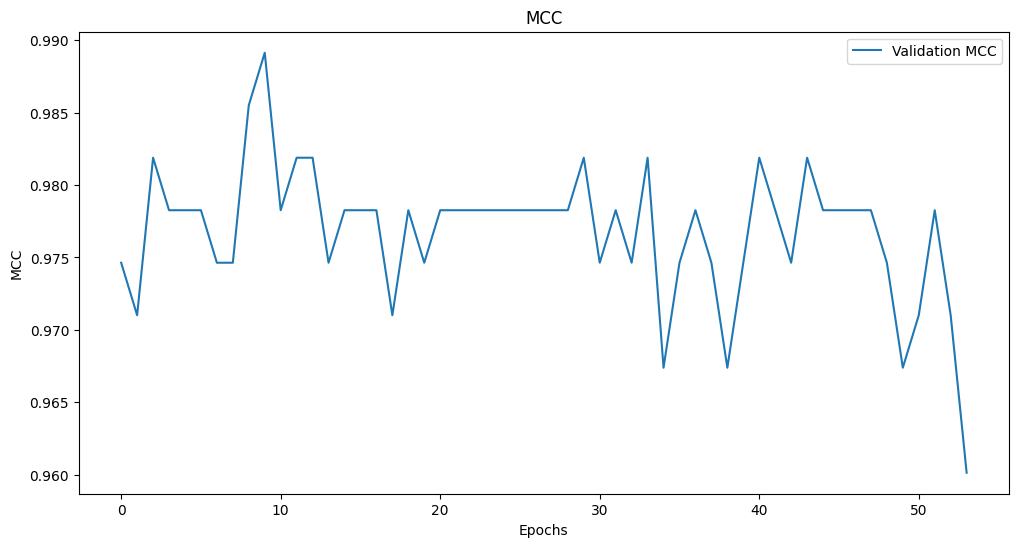

In [104]:
display_result(history_fine_tune_F20)

In [105]:
print_result()

18/18 [==============================] - 1s 39ms/step - loss: 0.0289 - accuracy: 0.9891 - mcc: 0.9792 - precision: 0.9896 - recall: 0.9896 - specificity: 0.9896 - f1_score: 0.9896 - auc: 0.9979
Validation Loss: 0.028855839744210243
Validation Accuracy: 0.989051103591919
Validation precision: 0.9791666865348816
Validation recall: 0.9895833134651184
Validation specificity: 0.9895833134651184
Validation f1_score: 0.9895833134651184
Validation AUC: 0.9895833134651184
Validation MCC: 0.9979187250137329


18/18 [==============================] - 2s 37ms/step


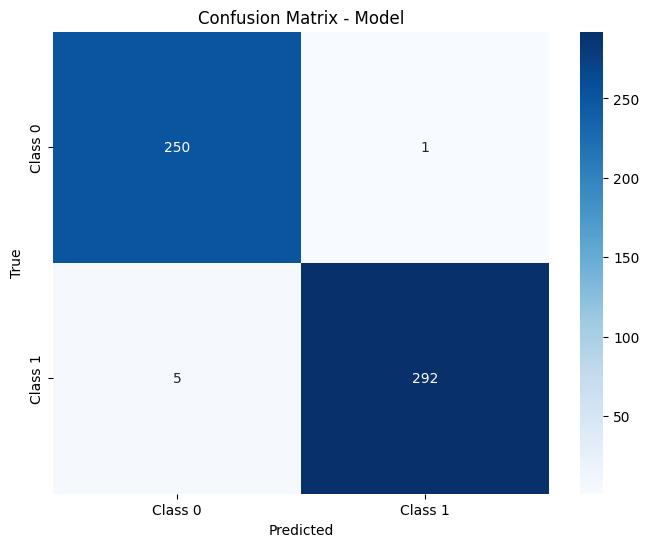

18/18 [==============================] - 1s 36ms/step


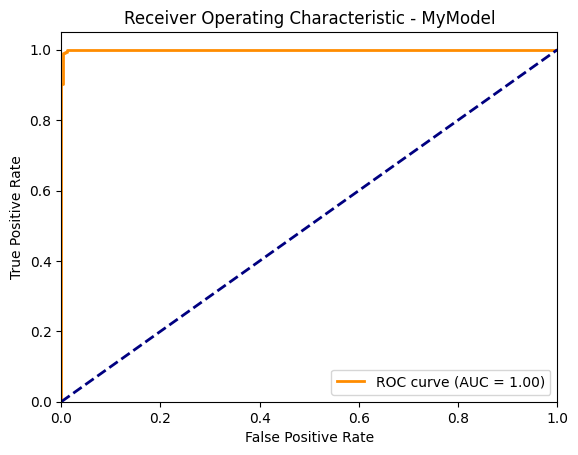

F1 Score: 0.9898304343223572


In [106]:
# Making predictions on the validation set
y_pred_probabilities = model_base.predict(X_val)

# Converting predicted probabilities to class labels
y_pred_classes = np.argmax(y_pred_probabilities, axis=1)

# Converting true labels to class labels if they are one-hot encoded
y_true_classes = np.argmax(y_val, axis=1)

# Ploting the confusion matrix
plot_confusion_matrix(y_true_classes, y_pred_classes)

plot_roc_auc(model_base, X_val, y_val, model_name="MyModel")

f1 = f1_score(y_true_classes, y_pred_classes)
print(f'F1 Score: {f1}')
